<div class="alert alert-block alert-success">
<a class="anchor" id="chapter0"></a>
<font color = '#006400'> 
    
# 0. Defining the Business Goal
</a>
    
</div>

• The study focuses on analyzing a discount program for products near their expiration date (pink tags). The goal is to understand the impact of price reductions and the timing of their application, identifying consumption patterns and developing strategies to maximize the program's efficiency.

• For this, sales and unsold product data were collected from various stores across Portugal for products that were labeled with the discount tag (pink tag) during October 2021. The provided data reflects a realistic scenario, but with imperfections typical of an operational environment. Analyzing this data will allow for the development of approaches to optimize pricing decisions and minimize waste associated with products reaching the end of their `shelf life.`

• The study is structured into several phases:<br>
1. Data Understanding and Processing<br>
2. Definition of Critical Variables for the Prediction Model<br>
3. Training, Validation, Hyperparameter Tuning, and Testing of the Model<br>
4. Presentation of Conclusions and Future Analyses that Could Enrich the Prediction Model and Discount Strategy.<br><br>

__Data_store.xlsx__

| Attribute         | Description                          |
| ----------------- | ------------------------------------ |
| Idstore           | Store where the label is applied     |
| type              | Store size                           |
| selling_square_ft | Store sales area                     |
| district          | Store location district              |

__Data_labels.xlsx__

| Attribute               | Description                                                                 |
| ----------------------- | --------------------------------------------------------------------------- |
| Idstore                 | Store where the label is applied                                            |
| Sku                     | Internal product identification (Stock Keeping Unit)                       |
| Brand                   | Product brand                                                               |
| Oldpvp                  | Price before the discount label application                                 |
| Newpvp (discount)       | Price applied during the discount labelling (discount applied)             |
| Labelqty                | Number of labels applied (always 1 in the dataset)                          |
| Weight                  | Weight of each SKU                                                           |
| Payment_method          | Payment method used in the sale                                              |
| Margin (%)              | Gross margin percentage of the item                                          |
| Profit (€)              | Gross profit in euros                                                       |
| perc_expiring_sku       | Proportion of remaining 'shelf life' at the time of the discount label application |
| expiring_date           | Product expiration date                                                     |
| labelling_date          | Date of discount labelling applied                                          |
| sell_date               | Date the product was sold                                                   |
| Sold                    | Boolean variable indicating whether the product was sold (=1) or not (=0) before its expiration |


<div class="alert alert-block alert-success">
<a class="anchor" id="chapter1"></a>
<font color = '#006400'> 
    
# 1. Importing Libraries and Datasets
</a>
    
</div>

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.1. Import the needed libraries
    
</div>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')

#################################################################### CHI SQUARE TEST ###################################################################
from scipy.stats import chi2_contingency

################################################################# FEATURE SELECTION IMPORTS ############################################################
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

################################################################# KFOLD TRAINING-TESTING ###############################################################
from sklearn.model_selection import StratifiedKFold

################################################################# TRAIN-TEST SPLIT #####################################################################
from sklearn.model_selection import train_test_split

################################################################# PREPROCESSING #################################################################
from sklearn.preprocessing import MinMaxScaler

################################################# MODELS #####################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

################################################# METRICS ####################################################################
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, precision_recall_curve,roc_curve

################################### MODEL SELECTION & OPTIMIZATION ###########################################################
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

################################### LOG TRANSFORMATION###########################################################################
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

################################### CLUSTERING ###########################################################################
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.2. Datasets
    
</div>

In [6]:
df_store = pd.read_excel(r'Data_store.xlsx')
df_store

idstore   type  selling_square_ft        district
0          1  Large             4762.0           Évora
1          2  Large            12358.0        Bragança
2          3  Large            16159.0          Lisboa
3          4  Large            17903.0           Porto
4          5  Large            16179.0         Coimbra
..       ...    ...                ...             ...
337      338  Small             1935.0          Leiria
338      339  Small             2680.0      Portalegre
339      340  Small              866.0         Coimbra
340      341  Small                NaN  Castelo Branco
341      342  Small              403.0            Beja

[342 rows x 4 columns]

In [7]:
df_labels = pd.read_excel(r'Data_labels.xlsx')
df_labels.head(18)

idstore  sku      brand oldpvp new_pvp (discount)  labelqty weight (g)  \
0         1    1   Marca  1   4.22        2.11 (0.50)         1        260   
1         1    1    Marca 1   3.96        1.98 (0.50)         1        260   
2         1    1   Marca  1   4.74        2.37 (0.50)         1        260   
3         1    1    Marca 1    4.2         2.1 (0.50)         1        260   
4         1    1   Marca  1   4.62        2.31 (0.50)         1        260   
5         1    1  Marca   1   4.62        2.31 (0.50)         1        260   
6         1    1     Marca1   3.42        1.71 (0.50)         1        260   
7         1    1   Marca  1   3.62        1.81 (0.50)         1        260   
8         1    1     Marca1   4.62        2.31 (0.50)         1        260   
9         1    1   Marca  1   4.38        2.19 (0.50)         1        260   
10        1    1  Marca   1   5.23                NaN         1        260   
11        1    1   Marca  1   5.89        2.94 (0.50)         1        260   
12        1    1    Marca 1   3.78        1.89 (0.50)         1        260   
13        1    1  Marca   1   4.76        2.38 (0.50)         1        260   
14        2    2   marca  2   3.19        1.59 (0.50)         1        222   
15        2    2    marca 2    NaN        1.59 (0.50)         1        222   
16        2    2     marca2   3.19        1.59 (0.50)         1        222   
17        2    2   marca  2   3.19        1.59 (0.50)         1        222   

   Payment_method  Margin (%)  Profit (€)  perc_expiring_sku expiring_date  \
0            Card          16      0.3376           0.010050    03/10/2021   
1                          16      0.3168           0.005025    02/10/2021   
2            Cash          16      0.3792           0.010050    03/10/2021   
3            Card          16      0.3360           0.010050    03/10/2021   
4            Cash          16      0.3696           0.010050    03/10/2021   
5            Cash          16      0.3696           0.010050    03/10/2021   
6            Cash          16      0.2736           0.005025    02/10/2021   
7            Card          16      0.2896           0.005025    02/10/2021   
8                          16      0.3696           0.005025    02/10/2021   
9            Card          16      0.3504           0.010050    03/10/2021   
10           Card          16      0.4176           0.010050    03/10/2021   
11           Cash          16      0.4704           0.010050    03/10/2021   
12           Cash          16      0.3024           0.010050    03/10/2021   
13                         16      0.3808           0.010050    03/10/2021   
14           Cash          15      0.2385           0.121212    25/10/2021   
15           Cash          15      0.2385           0.121212    25/10/2021   
16           Card          15      0.2385           0.121212    25/10/2021   
17           Cash          15      0.2385           0.121212    25/10/2021   

   labelling_date  sell_date  sold  
0      2021-10-01 2021-10-02   1.0  
1      2021-10-01        NaT   0.0  
2      2021-10-01 2021-10-03   1.0  
3      2021-10-01 2021-10-02   1.0  
4      2021-10-01 2021-10-03   NaN  
5      2021-10-01 2021-10-03   NaN  
6      2021-10-01 2021-10-02   1.0  
7      2021-10-01 2021-10-02   1.0  
8      2021-10-01        NaT   0.0  
9      2021-10-01 2021-10-02   1.0  
10     2021-10-01 2021-10-03   1.0  
11     2021-10-01 2021-10-02   1.0  
12     2021-10-01 2021-10-02   1.0  
13     2021-10-01        NaT   0.0  
14     2021-10-13 2021-10-14   1.0  
15     2021-10-13 2021-10-14   1.0  
16     2021-10-13 2021-10-15   1.0  
17     2021-10-13 2021-10-16   1.0

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.3. Merging the Datasets
    
</div>

In [548]:
df = df_labels.merge(df_store, on = 'idstore')

<div class="alert alert-block alert-info">
    
<a id='number_clusters'></a>

### 1.4. Check for duplicates
    
</div>

In [551]:
df[df.duplicated()]

idstore  sku      brand oldpvp new_pvp (discount)  labelqty  \
36            7    2     Marca2   3.19        2.39 (0.25)         1   
39            7    2    Marca 2   3.19        2.39 (0.25)         1   
41            7    2    Marca 2   3.19        2.39 (0.25)         1   
42            7    2   Marca  2   3.19        2.39 (0.25)         1   
43            7    2    Marca 2   3.19        2.39 (0.25)         1   
...         ...  ...        ...    ...                ...       ...   
150034      177  318     Marca2   2.49         1,24 (50%)         1   
150036      177  318    Marca 2   2.49         1,24 (50%)         1   
150038      177  318  Marca   2   2.49         1,24 (50%)         1   
150048      193  318   Marca  2   2.49        1.24 (0.50)         1   
150051      203  318     Marca2   2.49        1.24 (0.50)         1   

       weight (g) Payment_method  Margin (%)  Profit (€)  perc_expiring_sku  \
36            222                         15      0.3585           0.111111   
39            222                         15      0.3585           0.111111   
41            222                         15      0.3585           0.111111   
42            222                         15      0.3585           0.111111   
43            222                         15      0.3585           0.111111   
...           ...            ...         ...         ...                ...   
150034         97                         11      0.1364           0.006289   
150036         97                         11      0.1364           0.006289   
150038         97                         11      0.1364           0.006289   
150048         97           Cash          11      0.1364           0.100629   
150051         97           Cash          11      0.1364           0.113208   

       expiring_date labelling_date  sell_date  sold    type  \
36        26/10/2021     2021-10-15        NaT   0.0   Large   
39        26/10/2021     2021-10-15        NaT   0.0   Large   
41        26/10/2021     2021-10-15        NaT   0.0   Large   
42        26/10/2021     2021-10-15        NaT   0.0   Large   
43        26/10/2021     2021-10-15        NaT   0.0   Large   
...              ...            ...        ...   ...     ...   
150034    19-10-2021     2021-10-18        NaT   0.0   Small   
150036    19-10-2021     2021-10-18        NaT   0.0   Small   
150038    19-10-2021     2021-10-18        NaT   0.0   Small   
150048    19-10-2021     2021-10-03 2021-10-09   1.0  Medium   
150051    19-10-2021     2021-10-01 2021-10-02   1.0  Medium   

        selling_square_ft district  
36                13618.0   Guarda  
39                13618.0   Guarda  
41                13618.0   Guarda  
42                13618.0   Guarda  
43                13618.0   Guarda  
...                   ...      ...  
150034              842.0    Porto  
150036              842.0    Porto  
150038              842.0    Porto  
150048             5048.0    Viseu  
150051             9370.0     Faro  

[33740 rows x 18 columns]

Despite the presence of seemingly duplicate rows, no removal will be performed as they represent different units of the same SKU, labeled with the same information.

Even though the data may appear identical, each unit might be associated with different batches or separate sales, which is crucial for understanding the actual performance of the product. Therefore, removing these records would affect the analysis, hiding important information about sales behavior and inventory management.

<div class="alert alert-block alert-success">
<a id='import'>
<font color = '#006400'> 
    
# 2. Explore Data
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='basic'></a>

## 2.1. Basic Exploration
    
</div>

In [556]:
df.shape

(150054, 18)

In [558]:
df.columns

Index(['idstore', 'sku', 'brand', 'oldpvp', 'new_pvp (discount)', 'labelqty',
       'weight (g)', 'Payment_method', 'Margin (%)', 'Profit (€)',
       'perc_expiring_sku', 'expiring_date', 'labelling_date', 'sell_date',
       'sold', 'type', 'selling_square_ft', 'district'],
      dtype='object')

In [560]:
df.head(20)

idstore  sku      brand oldpvp new_pvp (discount)  labelqty weight (g)  \
0         1    1   Marca  1   4.22        2.11 (0.50)         1        260   
1         1    1    Marca 1   3.96        1.98 (0.50)         1        260   
2         1    1   Marca  1   4.74        2.37 (0.50)         1        260   
3         1    1    Marca 1    4.2         2.1 (0.50)         1        260   
4         1    1   Marca  1   4.62        2.31 (0.50)         1        260   
5         1    1  Marca   1   4.62        2.31 (0.50)         1        260   
6         1    1     Marca1   3.42        1.71 (0.50)         1        260   
7         1    1   Marca  1   3.62        1.81 (0.50)         1        260   
8         1    1     Marca1   4.62        2.31 (0.50)         1        260   
9         1    1   Marca  1   4.38        2.19 (0.50)         1        260   
10        1    1  Marca   1   5.23                NaN         1        260   
11        1    1   Marca  1   5.89        2.94 (0.50)         1        260   
12        1    1    Marca 1   3.78        1.89 (0.50)         1        260   
13        1    1  Marca   1   4.76        2.38 (0.50)         1        260   
14        2    2   marca  2   3.19        1.59 (0.50)         1        222   
15        2    2    marca 2    NaN        1.59 (0.50)         1        222   
16        2    2     marca2   3.19        1.59 (0.50)         1        222   
17        2    2   marca  2   3.19        1.59 (0.50)         1        222   
18        2    2    marca 2   3.19        1.59 (0.50)         1        222   
19        2    2    marca 2   3.19        1.59 (0.50)         1        222   

   Payment_method  Margin (%)  Profit (€)  perc_expiring_sku expiring_date  \
0            Card          16      0.3376           0.010050    03/10/2021   
1                          16      0.3168           0.005025    02/10/2021   
2            Cash          16      0.3792           0.010050    03/10/2021   
3            Card          16      0.3360           0.010050    03/10/2021   
4            Cash          16      0.3696           0.010050    03/10/2021   
5            Cash          16      0.3696           0.010050    03/10/2021   
6            Cash          16      0.2736           0.005025    02/10/2021   
7            Card          16      0.2896           0.005025    02/10/2021   
8                          16      0.3696           0.005025    02/10/2021   
9            Card          16      0.3504           0.010050    03/10/2021   
10           Card          16      0.4176           0.010050    03/10/2021   
11           Cash          16      0.4704           0.010050    03/10/2021   
12           Cash          16      0.3024           0.010050    03/10/2021   
13                         16      0.3808           0.010050    03/10/2021   
14           Cash          15      0.2385           0.121212    25/10/2021   
15           Cash          15      0.2385           0.121212    25/10/2021   
16           Card          15      0.2385           0.121212    25/10/2021   
17           Cash          15      0.2385           0.121212    25/10/2021   
18           Cash          15      0.2385           0.121212    25/10/2021   
19           Card          15      0.2385           0.121212    25/10/2021   

   labelling_date  sell_date  sold   type  selling_square_ft  district  
0      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
1      2021-10-01        NaT   0.0  Large             4762.0     Évora  
2      2021-10-01 2021-10-03   1.0  Large             4762.0     Évora  
3      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
4      2021-10-01 2021-10-03   NaN  Large             4762.0     Évora  
5      2021-10-01 2021-10-03   NaN  Large             4762.0     Évora  
6      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
7      2021-10-01 2021-10-02   1.0  Large             4762.0     Évora  
8      2021-10-01        NaT   0.0  Large             4762.0     Évor

In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150054 entries, 0 to 150053
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idstore             150054 non-null  int64         
 1   sku                 150054 non-null  int64         
 2   brand               150054 non-null  object        
 3   oldpvp              150032 non-null  object        
 4   new_pvp (discount)  150026 non-null  object        
 5   labelqty            150054 non-null  int64         
 6   weight (g)          150050 non-null  object        
 7   Payment_method      150054 non-null  object        
 8   Margin (%)          150054 non-null  int64         
 9   Profit (€)          150054 non-null  float64       
 10  perc_expiring_sku   149929 non-null  float64       
 11  expiring_date       150054 non-null  object        
 12  labelling_date      150054 non-null  datetime64[ns]
 13  sell_date           80511 non

<div class="alert alert-block alert-warning">

<a id='basic'></a>

## 2.2. Statistical Exploration
    
</div>

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 2.2.1. Numerical Variables
    
</div>

In [566]:
df.describe()

idstore            sku  labelqty     Margin (%)     Profit (€)  \
count  150054.000000  150054.000000  150054.0  150054.000000  150054.000000   
mean      139.234242     163.699422       1.0      15.824950       0.175131   
min         1.000000       1.000000       1.0      10.000000       0.034000   
25%        59.000000      99.000000       1.0      13.000000       0.124500   
50%       135.000000     160.000000       1.0      17.000000       0.152900   
75%       212.000000     236.000000       1.0      19.000000       0.222400   
max       332.000000     319.000000       1.0      20.000000      99.900000   
std        87.056044      87.247006       0.0       3.303568       0.268439   

       perc_expiring_sku                 labelling_date  \
count      149929.000000                         150054   
mean            0.385245  2021-10-16 16:41:47.577271808   
min             0.000000            2021-10-01 00:00:00   
25%             0.200000            2021-10-10 00:00:00   
50%             0.333333            2021-10-17 00:00:00   
75%             0.666667            2021-10-25 00:00:00   
max             2.000000            2021-10-31 00:00:00   
std             0.223626                            NaN   

                           sell_date           sold  selling_square_ft  
count                          80511  149940.000000      139275.000000  
mean   2021-10-17 18:22:01.846704384       0.536568        5978.197487  
min              2021-10-01 00:00:00       0.000000          10.000000  
25%              2021-10-11 00:00:00       0.000000        1218.000000  
50%              2021-10-18 00:00:00       1.000000        4982.000000  
75%              2021-10-25 00:00:00       1.000000        8671.000000  
max              2021-11-18 00:00:00       1.000000       25258.000000  
std                              NaN       0.498663        5533.809602

Da tabela anterior podemos tirar algumas conclusões, como:
- `count`- The dataset df contains missing values in the numerical variables perc_expiring_sku, sell_date, sold, and selling_square_ft;
- `mean`- The dataset is almost balanced between sold and unsold items (0.53);
- `min` e `max`- The labeling of items in the analysis was performed throughout October 2021, and the variable perc_expiring_sku has a maximum value of 2, which doesn't make sense in the context of this variable;
- `std`- The standard deviation of the selling_square_ft variable is relatively large compared to the mean, which might indicate the presence of outliers;
- `quartis`- It is observed that the variable selling_square_ft has a third quartile significantly higher than the mean, indicating a right-skewed distribution. This suggests a large number of stores with small sales areas and fewer stores with large sales areas, or potentially outliers;
- The variables 'idstore' and 'sku' should not be classified as numerical but rather as categorical, as their statistical analysis at this step doesn't make sense.

In [569]:
df['sold'].value_counts()

sold
1.0    80453
0.0    69487
Name: count, dtype: int64

In [571]:
sales_count = df['sell_date'].value_counts().sum()
non_sales_count = df['sell_date'].isna().sum()
print(sales_count)
print(non_sales_count)

80511
69543


A difference is observed between the number of observations with the variable sold equal to 1 and the number of observations where the sell_date variable is not null. <br> This difference will be analyzed and corrected in subsequent steps to ensure consistency for the analysis.

In [574]:
df.skew(numeric_only=True)

idstore                0.166375
sku                   -0.072151
labelqty               0.000000
Margin (%)            -0.374411
Profit (€)           341.717605
perc_expiring_sku      0.261184
sold                  -0.146666
selling_square_ft      1.091003
dtype: float64

Through the analysis of skewness, it is observed:
- `High Skewness (greater than |1.0|)`: Profit (€) and selling_square_ft
- `Skewness equal to 0:` The 'labelqty' variable is constant, so it will be disregarded in the analysis. 


In [577]:
df.kurt(numeric_only=True)

idstore                  -1.121767
sku                      -1.118777
labelqty                  0.000000
Margin (%)               -1.260135
Profit (€)           126938.236692
perc_expiring_sku        -0.022512
sold                     -1.978515
selling_square_ft         0.693269
dtype: float64

Based on the previous analysis, the suspicion of the presence of outliers in the 'Profit (€)' variable is reinforced due to the high kurtosis value (greater than 3.0).

In conclusion, it is important to check for possible outliers in the following variables:

- 'selling_square_ft'
- 'Profit (€)'

<div class="alert alert-block alert-info">
    
<a id='stats_cat'></a>

### 2.2.2. Categorical Variables
    
</div>

In [581]:
df.describe(include = ['O'])

brand     oldpvp new_pvp (discount)  weight (g) Payment_method  \
count     150054  150032.00             150026      150050         150054   
unique       328     140.00                396         189              3   
top      marca 2       1.19        0.83 (0.30)         121                  
freq       18249   22234.00              18219        9521          69543   

       expiring_date    type district  
count         150054  150054   150054  
unique            84       4       18  
top       28/10/2021  Medium   Lisboa  
freq            4741   62590    14888

Based on the analysis presented above, the following conclusions can be drawn:

- There are missing values in the variables `oldpvp`, `new_pvp (discount)` e `weight (g)`;
- The variable `district` has 18 unique values, suggesting that all districts of mainland Portugal are represented in the dataset, with the Lisbon district being the most represented.
- The variable `payment_method` has 3 possible values, with the blank space being the most frequent and occurring in the same amount as the number of unsold products. It is likely associated with an unsold product, but it needs to be transformed into a more understandable value.
- The variable `expiring_date` is not classified as a date, which may indicate a formatting error in its values.;
- The variables `oldpvp`, `new_pvp (discount)` e `weight (g)` should not be classified as categorical, but rather as numeric;
- It is observed that the variable `new_pvp (discount)` contains special characters that prevent it from being classified as numeric. The same should be done for the remaining variables;

In [584]:
df['brand'].value_counts().head(20)

brand
 marca 2     18249
 Marca 2     17008
marca  2      9077
marca   2     9068
marca2        9043
marca 2       9037
Marca2        8840
Marca 2       8672
Marca  2      8616
Marca   2     8553
 Marca 7      2739
 marca 7      2426
 Marca 15     2051
 marca 15     1983
Marca7        1447
Marca 7       1385
Marca  7      1333
Marca   7     1319
marca  7      1227
marca 7       1197
Name: count, dtype: int64

It is confirmed that there are several repeated names but with different spellings in the `brand` variable. This will be addressed in subsequent steps.

In [587]:
df['expiring_date'].value_counts().head(10)

expiring_date
28/10/2021    4741
29/10/2021    4737
22/10/2021    4543
15/10/2021    4481
22-10-2021    4440
21/10/2021    4380
23/10/2021    4196
29-10-2021    4156
07/10/2021    3877
15-10-2021    3831
Name: count, dtype: int64

It is confirmed that there are dates with different formats in the `expiring_date` variable, preventing its automatic classification as a date variable.<br> These values will be transformed in subsequent steps."

In [590]:
df['Payment_method'].value_counts().head(20)

Payment_method
        69543
Card    40398
Cash    40113
Name: count, dtype: int64

It is confirmed that there is an empty category in the `Payment_method` variable, which is likely associated with an unsold item but needs to be transformed into a more understandable value. These cases will be addressed in subsequent steps.

In [593]:
df['type'].value_counts()

type
Medium    62590
Small     60599
Large     26219
0           646
Name: count, dtype: int64

It is confirmed that there are values in the `type` variable equal to 0. These missing values will be addressed in subsequent steps.

In [596]:
df['district'].value_counts()

district
Lisboa              14888
Porto               12018
Coimbra             10694
Braga               10050
Guarda               9699
Viana do Castelo     8943
Aveiro               8650
Viseu                8421
Castelo Branco       7770
Beja                 7664
Bragança             7230
Setúbal              7207
Évora                6975
Portalegre           6857
Vila Real            6820
Faro                 6432
Santarém             5946
Leiria               3790
Name: count, dtype: int64

It is confirmed that all 18 districts of mainland Portugal are present in the dataset, with a higher predominance of districts with major urban centers (Lisbon, Porto, Coimbra, and Braga).

In [599]:
df['weight (g)'].head(50)

0     260
1     260
2     260
3     260
4     260
5     260
6     260
7     260
8     260
9     260
10    260
11    260
12    260
13    260
14    222
15    222
16    222
17    222
18    222
19    222
20    222
21    222
22    222
23    222
24    222
25    222
26    222
27    222
28    222
29    222
30    222
31    222
32    222
33    222
34    222
35    222
36    222
37    222
38    222
39    222
40    222
41    222
42    222
43    222
44    222
45    222
46    NaN
47    222
48    222
49    222
Name: weight (g), dtype: object

It is observed that there are `NaN` values in the 'weight (g)' variable of the dataset. Since this does not prevent classification as int64, it is likely that special characters, such as blank spaces, are present.

In [602]:
df['oldpvp'].tail(10)

150044    2,49
150045    2.49
150046    2.49
150047    2.49
150048    2.49
150049    2.49
150050    2.49
150051    2.49
150052    3.49
150053    3.49
Name: oldpvp, dtype: object

It is observed that the values in the 'oldpvp' variable use a comma as the decimal separator instead of a period, which is why the variable is classified as 'object' instead of 'float64'. These values will be transformed in later steps.

In [605]:
df['new_pvp (discount)'].tail(10)

150044     1,24 (50%)
150045    1.24 (0.50)
150046    1.24 (0.50)
150047    1.24 (0.50)
150048    1.24 (0.50)
150049    1.24 (0.50)
150050    1.24 (0.50)
150051    1.24 (0.50)
150052    2.44 (0.30)
150053    2.44 (0.30)
Name: new_pvp (discount), dtype: object

In addition to the previous points, it is observed that there are records with decimal format and others with percentage format in the 'new_pvp (discount)' variable.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 3. Preprocess Data
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='clean'></a>

## 3.1. Data Cleaning
    
</div>

<div class="alert alert-block alert-info">

<a id='missing'></a>

### 3.1.1. Missing Values
    
</div>

In section 2, it was found that the dataset has missing values in the variables  `oldpvp`, `new_pvp (discount)`, `weight (g)`, `perc_expiring_sku`, `sell_date`, `sold` e `selling_square_ft`, while the variables `Payment_method` and `type` contain characters or spaces, which are also considered as missing values. In the following command, we checked the presence of some of these values.

In [612]:
df.isna().sum()

idstore                   0
sku                       0
brand                     0
oldpvp                   22
new_pvp (discount)       28
labelqty                  0
weight (g)                4
Payment_method            0
Margin (%)                0
Profit (€)                0
perc_expiring_sku       125
expiring_date             0
labelling_date            0
sell_date             69543
sold                    114
type                      0
selling_square_ft     10779
district                  0
dtype: int64

#### 3.1.1.1 Changing Values of the 'sold' Variable

In the dataset, it has been observed that there are entries with dates in the `sell_date` variable, but the corresponding value of the `sold` variable is not equal to 1. At this point, we consider the `sell_date` variable to be correct. Therefore, the value of the `sold` variable will be replaced with 1 whenever the `sell_date` variable is filled.

In [616]:
df.loc[(df['sold'] != 1) & (df['sell_date'].notna()),'sold']=1

As observed, the opposite situation also occurs, where there are entries without a value in the `sell_date` variable, but the `sold` variable is not 0.<br>
Therefore, the value of the `sold` variable will be replaced with 0 whenever the `sell_date` variable is empty.

In [619]:
df.loc[(df['sold'].isna()) & (df['sell_date'].isna()),'sold']=0

In [621]:
df['sold'].value_counts()

sold
1.0    80511
0.0    69543
Name: count, dtype: int64

In [623]:
sales_count = df['sell_date'].value_counts().sum()
non_sales_count = df['sell_date'].isna().sum()
print(sales_count)
print(non_sales_count)

80511
69543


This confirms the equality in the number of sold items <b>(80511)</b> and sale dates <b>(80511)</b>, as well as for the unsold items and the absence of sale dates <b>(69543)</b>, validating the transformations that were carried out.

#### 3.1.1.2 Splitting the 'new_pvp (discount)' Variable

The components of the 'new_pvp (discount)' variable should be treated and analyzed separately, that is, the 'new_pvp' value and the 'discount' value. <br> Therefore, the variable will be split into two new variables: 'new_pvp' and 'discount'.


In [628]:
df['new_pvp'] = df['new_pvp (discount)'].astype(str).str.split(' ').str[0]
df['discount'] = df['new_pvp (discount)'].astype(str).str.split(' ').str[1]

In [629]:
df[['new_pvp (discount)','new_pvp','discount']].head(11)

new_pvp (discount) new_pvp discount
0         2.11 (0.50)    2.11   (0.50)
1         1.98 (0.50)    1.98   (0.50)
2         2.37 (0.50)    2.37   (0.50)
3          2.1 (0.50)     2.1   (0.50)
4         2.31 (0.50)    2.31   (0.50)
5         2.31 (0.50)    2.31   (0.50)
6         1.71 (0.50)    1.71   (0.50)
7         1.81 (0.50)    1.81   (0.50)
8         2.31 (0.50)    2.31   (0.50)
9         2.19 (0.50)    2.19   (0.50)
10                NaN     nan      NaN

It is observed that the values of the new 'discount' variable require additional processing so that it can be converted into the float64 format, by removing special characters and replacing commas with periods.

In [631]:
df['discount'] = df['discount'].apply(lambda x: str(x).replace('(', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace(')', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace('%', '') if pd.notna(x) else x)
df['discount'] = df['discount'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)

df['discount'] = df['discount'].astype('float')

In [633]:
df['discount'].tail(10)

150044    50.0
150045     0.5
150046     0.5
150047     0.5
150048     0.5
150049     0.5
150050     0.5
150051     0.5
150052     0.3
150053     0.3
Name: discount, dtype: float64

As previously verified, there are 'discount' values that are in percentage form and need to be converted into decimal form.

In [636]:
df.loc[df['discount'] > 1, 'discount'] = df.loc[df['discount'] > 1, 'discount'] / 100

In [637]:
df['discount'].describe()

count    150026.000000
mean          0.302269
std           0.036940
min           0.010000
25%           0.300000
50%           0.300000
75%           0.300000
max           0.990000
Name: discount, dtype: float64

It is verified that the values of the variable are within the expected range [0-1]. 
Next, we proceed with the correction of the decimal separators in the 'new_pvp' variable and the removal of the 'new_pvp (discount)' variable.

In [641]:
df['new_pvp'] = df['new_pvp'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)
df['new_pvp'] = df['new_pvp'].astype('float')

In [644]:
df.drop('new_pvp (discount)', axis=1, inplace=True)

#### 3.1.1.3 Filling missing values of the 'new_pvp' variable

Through the values of the 'Profit (€)' and 'Margin (%)' variables, it is possible to obtain the missing values of the 'new_pvp' variable.

In [649]:
df.loc[df['new_pvp'].isna() & df['Margin (%)'].notna() & df['Profit (€)'].notna(), 'new_pvp'] = df['Profit (€)'] / df['Margin (%)'] *100

#### 3.1.1.4 Filling missing values of the 'oldpvp' variable

Similarly, it is also possible to obtain missing values of the 'oldpvp' variable using the 'new_pvp' and 'discount' variables. For this, it is necessary to correct the decimal separator and change the variable format.

In [653]:
df['oldpvp'] = df['oldpvp'].apply(lambda x: str(x).replace(',', '.') if pd.notna(x) else x)
df['oldpvp'] = df['oldpvp'].astype('float')

In [654]:
df.loc[df['oldpvp'].isna() & df['new_pvp'].notna() & df['discount'].notna(), 'oldpvp'] = df['new_pvp'] / (1 - df['discount'])

#### 3.1.1.5 Filling missing values of the 'discount' variable

Finally, the missing values of the 'discount' variable can be obtained using the 'new_pvp' and 'oldpvp' variables.

In [659]:
df.loc[df['discount'].isna() & df['oldpvp'].notna() & df['new_pvp'].notna(), 'discount'] = df['new_pvp'] / df['oldpvp']

#### 3.1.1.6 Filling missing values of the 'weight (g)' variable 

The 'weight (g)' variable contains blank spaces that must be replaced with `NaN` before processing:

In [663]:
df['weight (g)'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

Through the analysis of the dataset, it is observed that the missing values belong to SKU's 2 and 4. The remaining records for these SKU's have the 'weight (g)' variable filled with the same value. Therefore, we will assume this value to fill the missing 'weight (g)' values when the SKU is 2 or 4:

In [666]:
df[df['sku'] == 2]['weight (g)'].value_counts()

weight (g)
222.0    101
Name: count, dtype: int64

In [668]:
df[df['sku'] == 4]['weight (g)'].value_counts()

weight (g)
134.0    453
Name: count, dtype: int64

In [670]:
peso_sku_2 = df.loc[df['sku'] == 2, 'weight (g)'].iloc[0]
df.loc[(df['sku'] == 2) & (df['weight (g)'].isna()), 'weight (g)'] = peso_sku_2

In [672]:
peso_sku_4 = df.loc[df['sku'] == 4, 'weight (g)'].iloc[0]
df.loc[(df['sku'] == 4) & (df['weight (g)'].isna()), 'weight (g)'] = peso_sku_4

The remaining empty records in the 'weight (g)' variable will be removed, as no significant impact is expected due to their small number:

In [675]:
df['weight (g)'].isna().sum()

424

In [677]:
df = df.dropna(subset=['weight (g)'])

#### 3.1.1.7 Filling missing values in the 'perc_expiring_sku' variable

As previously verified, there are blank values in the 'perc_expiring_sku' variable.<br>
Some of these values can be filled with 0 when the values of the 'expiring_date' and 'labelling_date' variables are equal.

In [681]:
df.loc[df['expiring_date'] == df['labelling_date'], 'perc_expiring_sku'] = 0

The remaining empty records in the 'perc_expiring_sku' variable will be deleted, as it is not expected to have any significant impact due to their small number.

In [684]:
df['perc_expiring_sku'].isna().sum()

80

The remaining values in the 'perc_expiring_sku' variable will be deleted:

In [687]:
df = df.dropna(subset=['perc_expiring_sku'])

#### 3.1.1.8 Filling missing values in the 'Payment_method' variable

Through previous analyses, it is verified that the 'Payment_method' variable was filled with a blank space when the product was not sold.<br> To facilitate analysis, the value 'No_Payment' will be assigned to this variable when the 'sold' value is equal to 0:

In [691]:
df.loc[df['sold']== 0,'Payment_method'] = 'No_Payment'

#### 3.1.1.9 Filling missing values in the 'type' variable

The value of 'type' is 0 only when 'selling_square_ft' has null values. <br> Thus, to fill in the 'type' variable with values equal to 0, the most frequent 'type' was determined when 'selling_square_ft' is null:

In [695]:
df[df['selling_square_ft'].isna()].groupby('type').size()

type
0          646
Medium    2028
Small     8078
dtype: int64

Considering the mode of this subset of null 'selling_square_ft' values, 'Small' will be assigned to 'type' values equal to 0:

In [698]:
df.loc[df['type'] == 0, 'type'] = 'Small'

#### 3.1.1.10 Filling missing values in the 'selling_square_ft' variable

The missing values of the 'selling_square_ft' variable will be filled with the average of the remaining values for the same store type and district, as it can be observed that the store size within the same type varies from district to district.

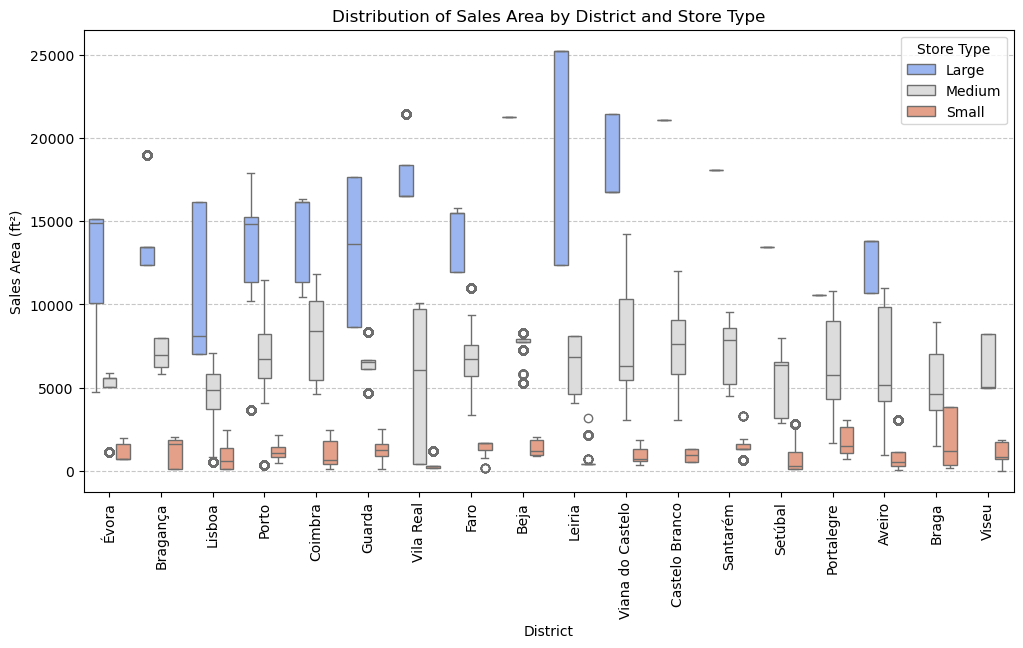

In [702]:
if {"district", "selling_square_ft", "type"}.issubset(df.columns):
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df["district"], y=df["selling_square_ft"], hue=df["type"], palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title("Distribution of Sales Area by District and Store Type")
    plt.xlabel("District")
    plt.ylabel("Sales Area (ft²)")
    plt.legend(title="Store Type")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(":x_red_circle: Error: The DataFrame does not contain all the necessary columns (district, selling_square_ft, type).")


In [704]:
df["selling_square_ft"] = df.groupby(["district", "type"])["selling_square_ft"].transform(lambda x: x.fillna(x.mean())).round(0)

<div class="alert alert-block alert-info">

<a id='outliers'></a>

### 3.1.2. Correction of Formatting
    
</div>

#### 3.1.2.1 Correction of the formatting of the 'expiring_date' variable

In this step, the characters that prevent the classification of the 'expiring_date' variable as a datetime type variable are replaced:

In [170]:
df['expiring_date'] = df['expiring_date'].str.replace('-', '/', regex=False)

In [171]:
df['expiring_date']=pd.to_datetime(df['expiring_date'], format="%d/%m/%Y")

<div class="alert alert-block alert-info">

<a id='missing'></a>

### 3.1.3. Rounding of Values
    
</div>

In this section, the rounding of the variables `Perc_expiring_sku`, `Profit (€)`, `oldpvp` and `discount` will be carried out:

In [178]:
df['perc_expiring_sku']=round(df['perc_expiring_sku'],4)

In [180]:
df['Profit (€)']=round(df['Profit (€)'],4)

In [182]:
df['oldpvp']=round(df['oldpvp'],2)

In [184]:
df['discount']=round(df['discount'],3)

<div class="alert alert-block alert-warning">

<a id='transform'></a>

## 3.2. Data Transformation
    
</div>

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.1. Correction of Classifications
    
</div>

As previously observed, the 'brand' variable contains several repeated names but with different spellings. It will be normalized at this point:

In [189]:
df['brand'] = df['brand'].replace(r'\s+', '', regex=True).str.upper()

Next, the variables 'idstore' and 'sku' will be converted to 'object' type, and 'sold' will be converted to 'int64' type:

In [192]:
df[['idstore', 'sku']] = df[['idstore', 'sku']].astype('object')
df['sold'] = df['sold'].astype('int64')

<div class="alert alert-block alert-info">

<a id='inco'></a>

### 3.2.2. Correction of Inconsistencies
</div>

#### 3.2.2.1 Correction of values in the 'sell_date' variable

From a business perspective, it would not make sense for sale dates to occur after the labelling date ('labelling_date') or the expiration date ('expiring_date'), and this will be verified in this step:

In [197]:
df[(df['sell_date'] < df['labelling_date']) | (df['expiring_date'] < df['labelling_date'])]

idstore  sku   brand  oldpvp  labelqty  weight (g) Payment_method  \
1143       17    8  MARCA2    1.19         1       174.0           Card   
1144       17    8  MARCA2    1.19         1       174.0           Card   
1145       17    8  MARCA2    1.19         1       174.0           Cash   
1146       17    8  MARCA2    1.19         1       174.0           Card   
39214      17  102  MARCA2    0.99         1       188.0           Card   
39215      17  102  MARCA2    0.99         1       188.0           Cash   

       Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
1143           15      0.1245                0.2    2021-10-22     2021-10-21   
1144           15      0.1245                0.2    2021-10-22     2021-10-21   
1145           15      0.1245                0.2    2021-10-22     2021-10-21   
1146           15      0.1245                0.2    2021-10-22     2021-10-21   
39214          12      0.0828                0.5    2021-10-22     2021-10-21   
39215          12      0.0828                0.5    2021-10-22     2021-10-21   

       sell_date  sold   type  selling_square_ft          district  new_pvp  \
1143  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1144  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1145  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
1146  2021-10-20     1  Large            16732.0  Viana do Castelo     0.83   
39214 2021-10-20     1  Large            16732.0  Viana do Castelo     0.69   
39215 2021-10-20     1  Large            16732.0  Viana do Castelo     0.69   

       discount  
1143        0.3  
1144        0.3  
1145        0.3  
1146        0.3  
39214       0.3  
39215       0.3

It was found that such a situation occurs, and through an analysis of the labeling strategy of store 'ID17', it will be considered that the sale date occurred 1 day later, i.e., on the same day as the labeling date.

In [200]:
df.loc[(df['sell_date'] < df['labelling_date']) | (df['expiring_date'] < df['labelling_date']), 'sell_date'] = '2021-10-21'

#### 3.2.2.2 Correction of values in the 'perc_expiring_sku' variable

Considering that the 'perc_expiring_sku' variable should only take values between 0 and 1, it would not make sense to have values like 1.8 and 2, as observed. <br> After analyzing the SKUs, values equal to 2 will be replaced with 1, and the unique record of 1.8 will be removed.

In [204]:
df.loc[df['perc_expiring_sku']==2,'perc_expiring_sku'] = 1

In [206]:
df.drop(df[df["perc_expiring_sku"] == 1.8].index, inplace=True)

#### 3.2.2.3 Removal of values from the 'oldpvp' and 'new_pvp' variables

In the dataset, there are 2 observations with inconsistent values for 'oldpvp' (500 and 999), and since they are only 2 records, they will be removed.

In [210]:
df[(df["oldpvp"] == 999) | (df["oldpvp"] == 500)]

idstore  sku    brand  oldpvp  labelqty  weight (g) Payment_method  \
452        64    4   MARCA3   500.0         1       134.0           Card   
50171     289  108  MARCA20   999.0         1       227.0     No_Payment   

       Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
452            17      0.3315             0.2500    2021-10-30     2021-10-29   
50171          20     99.9000             0.1013    2021-10-10     2021-10-02   

       sell_date  sold    type  selling_square_ft          district  new_pvp  \
452   2021-10-29     1  Medium             7879.0          Santarém    250.0   
50171        NaT     0   Small              342.0  Viana do Castelo    499.5   

       discount  
452         0.5  
50171       0.5

In [212]:
df.drop(df[(df["oldpvp"] == 999) | (df["oldpvp"] == 500)].index, inplace=True)

#### 3.2.2.4 Change of inconsistent values in the 'discount' variables

An inconsistency in the 'discount' variable is observed for one observation of SKU 4. By consulting the other observations of the same SKU, it is possible to consider the value of the 'oldpvp' variable as correct. The values of 'new_pvp' and 'discount' will be corrected.

In [216]:
df[(df.index == 550)]

idstore sku   brand  oldpvp  labelqty  weight (g) Payment_method  \
550      83   4  MARCA3    2.79         1       134.0     No_Payment   

     Margin (%)  Profit (€)  perc_expiring_sku expiring_date labelling_date  \
550          17      0.3315                0.5    2021-10-09     2021-10-07   

    sell_date  sold    type  selling_square_ft district  new_pvp  discount  
550       NaT     0  Medium             4330.0    Braga   0.0279      0.99

In [218]:
df.loc[(df["discount"] == 0.99) & (df["sku"] == 4), "discount"] = 0.3
df.loc[(df["new_pvp"] == 0.0279) & (df["sku"] == 4), "new_pvp"] = 1.95

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.3. Creation of New Variables
    
</div>

#### 3.2.3.1 Conversion of datetime type variables

The analysis performed in PowerBI requires the creation of the following variables:

- `labelling_days_until_exp` which represents the difference in days between the labelling date and the expiration date;
- `labelling_days_until_sales` which represents the difference in days between the labelling date and the sale date (if it occurs);
- `sales_days_until_exp` which represents the difference in days between the sale date and the expiration date.

For the last two variables, when no sale occurs, the value is set to 999 for better distinction from sales. It is important to note that assigning the value "999" will have no impact on the models, as these variables, being directly associated with the "sale" event, will not be considered in the model.

In [223]:
df['labelling_date'] = pd.to_datetime(df['labelling_date'])

In [225]:
df['sell_date'] = df['sell_date'].astype(str).str.replace('-', '/', regex=False)

In [227]:
df['sell_date'] = pd.to_datetime(df['sell_date'], infer_datetime_format=True, errors='coerce')

In [229]:
df['labelling_days_until_exp'] = (df['expiring_date'] - df['labelling_date']).dt.days

In [231]:
df['labelling_days_until_sales'] = np.where(
    pd.notna(df['sell_date']),
    (df['sell_date'] - df['labelling_date']).dt.days,
    999
)

In [233]:
df['sales_days_until_exp'] = np.where(
    pd.notna(df['sell_date']),
    (df['expiring_date'] - df['sell_date']).dt.days,
    999
)

In [235]:
df[['sales_days_until_exp', 'labelling_days_until_sales']] = df[['sales_days_until_exp', 'labelling_days_until_sales']].astype('int64')

#### 3.2.3.3 Creation of the 'region' variable

In order to reduce the complexity of the model and improve generalization, the districts of Mainland Portugal will be grouped into regions, maintaining the geographical and economic patterns more effectively:

In [239]:
mapeamento_regioes = {
    'Aveiro': 'Centro',
    'Beja': 'Sul',
    'Braga': 'Norte',
    'Bragança': 'Norte',
    'Castelo Branco': 'Centro',
    'Coimbra': 'Centro',
    'Évora': 'Sul',
    'Faro': 'Sul',
    'Guarda': 'Centro',
    'Leiria': 'Centro',
    'Lisboa': 'Sul',
    'Portalegre': 'Sul',
    'Porto': 'Norte',
    'Santarém': 'Centro',
    'Setúbal': 'Sul',
    'Viana do Castelo': 'Norte',
    'Vila Real': 'Norte',
    'Viseu': 'Centro'
}

df['region'] = df['district'].map(mapeamento_regioes)

#### 3.2.3.4 Creation of the 'marca_2' flag variable

The dataset has a significant imbalance in the 'brand' variable, with approximately 70% of the data belonging to MARCA2. <br> To investigate whether the strong presence of MARCA2 influences our prediction, a flag variable will be created to indicate whether the brand is MARCA2 or not, and the 'brand' variable will be eliminated.

In [245]:
marca2 = df[df['brand'] == 'MARCA2'].shape[0]
not_marca2 = df[df['brand'] != 'MARCA2'].shape[0]
total = df.shape[0]

percent_marca2 = (marca2 / total) * 100
percent_not_marca2 = (not_marca2 / total) * 100

print(f"Number of rows with 'MARCA2': {marca2} ({percent_marca2:.2f}%)")
print(f"Number of rows without 'MARCA2': {not_marca2} ({percent_not_marca2:.2f}%)")

Number of rows with 'MARCA2': 106129 (70.97%)
Number of rows without 'MARCA2': 43418 (29.03%)


In [247]:
df['marca_2'] = df['brand'].apply(lambda x: 'yes' if x == 'MARCA2' else 'no')

#### 3.2.3.5 Creation of the variables 'skus_per_ft','skus_per_store','labelling_day_of_week','unique_skus_brand','skus_per_brand','product_cost'

For model training purposes, several variables will be created:

In [251]:
df['skus_per_ft'] = df.groupby('idstore')['sku'].transform('count') / df.groupby('idstore')['selling_square_ft'].transform('first')
df['skus_per_ft'] = df['skus_per_ft'].round(4)

In [253]:
df['skus_per_store'] = df.groupby('idstore')['sku'].transform('count')

In [255]:
df['labelling_day_of_week'] = df['labelling_date'].dt.dayofweek
df['labelling_day_of_week'] = df['labelling_day_of_week'].astype('category')

In [257]:
df['unique_skus_brand'] = df.groupby('brand')['sku'].transform('nunique')

In [259]:
df['product_cost'] = df['new_pvp'] * (1 - df['Margin (%)'] / 100)

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.4. Elimination of variables
    
</div>

The following variables will be eliminated:

- `labelqty` – due to being constant and not adding value to the model;
- `brand` and `district`- have been replaced by other variables;
- `Payment_method`, `sell_date`,`labelling_date`, `expiring_date`, `labelling_days_until_sales` e `sales_days_until_exp`- are variables associated with the target variable;
- `idstore` and `sku` – are unique identifiers and may cause the model to memorize rather than generalize.

In [263]:
df.drop('labelqty', axis=1, inplace=True)

In [265]:
df.drop('district', axis=1, inplace=True)

In [267]:
df.drop('Payment_method', axis=1, inplace=True)

In [269]:
df.drop('sell_date', axis=1, inplace=True)

In [271]:
df.drop('labelling_date', axis=1, inplace=True)

In [273]:
df.drop('expiring_date', axis=1, inplace=True)

In [275]:
df.drop('labelling_days_until_sales', axis=1, inplace=True)

In [277]:
df.drop('sales_days_until_exp', axis=1, inplace=True)

In [279]:
df.drop('idstore', axis=1, inplace=True)

In [281]:
df.drop('sku', axis=1, inplace=True)

In [283]:
df.drop('brand', axis=1, inplace=True)

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.5. Visual Exploration
    
</div>

#### 3.2.5.1 Numeric Variables

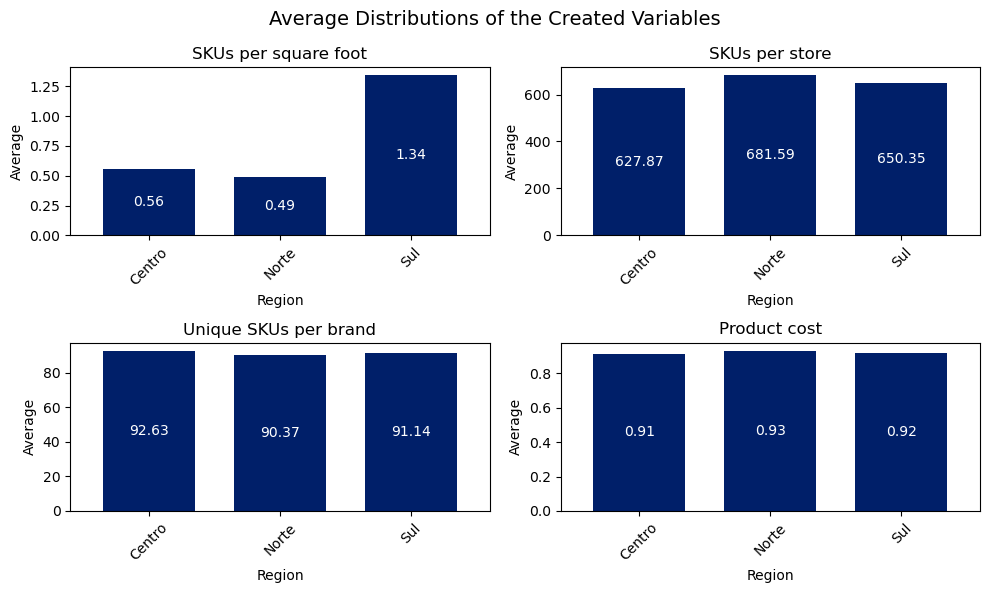

In [287]:
cols = ['skus_per_ft', 'skus_per_store', 'unique_skus_brand', 'product_cost']

mean_values = df.groupby('region')[cols].mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

metric_titles = ['SKUs per square foot', 'SKUs per store', 'Unique SKUs per brand', 'Product cost']

for i, (ax, col, title) in enumerate(zip(axes.flatten(), cols, metric_titles)):
    bars = mean_values[col].plot(kind='bar', ax=ax, color='#001F69', width=0.7)
    ax.set_title(title)
    ax.set_xlabel('Region')
    ax.set_ylabel('Average')
    ax.set_xticklabels(mean_values.index, rotation=45)
    for j, value in enumerate(mean_values[col]):
        ax.text(j, value / 2, str(round(value, 2)), ha='center', va='center', color='white')

plt.suptitle('Average Distributions of the Created Variables', fontsize=14, color='black')
plt.tight_layout()
plt.show()

From the analysis of the previous chart, the following conclusions are made:

- The South region has a significantly higher average 'SKUs per Feet' (1.34), more than double the averages of the Center (0.56) and the North (0.49).
- In terms of SKUs per store, the North leads with 681.59, followed by the South with 650.35, and the Center with 627.87.
- The difference between the North and the Center in SKUs per store is around 8.5%, indicating a higher quantity of discounted products per store in the North.
- The average number of unique SKUs per brand is very similar across regions, with the Center slightly leading (92.63), followed by the South (91.14), and then the North (90.37).
- The differences in unique SKUs per brand are minimal, suggesting a relatively uniform brand offering.
- The average product cost is slightly higher in the North (0.93), followed by the South (0.92), and the Center (0.91).

#### 3.2.5.2 Categorical Variables

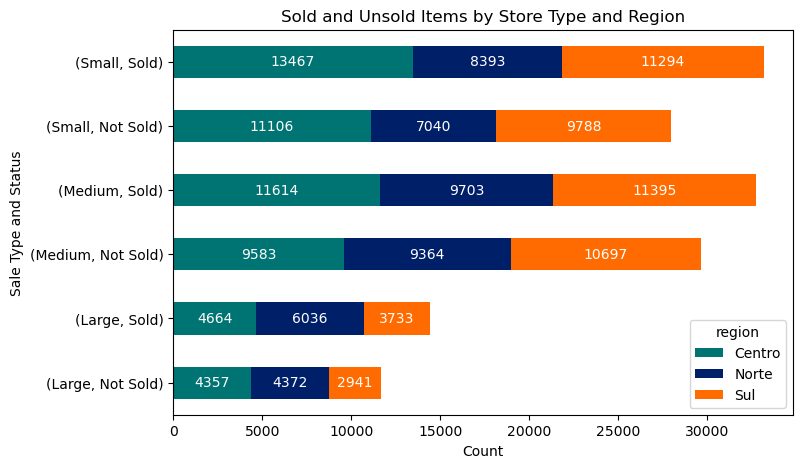

In [289]:
count_data = df.groupby(['type', df['sold'].replace({0: "Not Sold", 1: "Sold"}), 'region']).size().unstack(fill_value=0)

ax = count_data.plot(kind='barh', stacked=True, color=['#007473', '#001F69', '#FF6B00'], figsize=(8, 5))

for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            x_pos = bar.get_x() + width / 2
            y_pos = bar.get_y() + bar.get_height() / 2
            ax.text(x_pos, y_pos, f'{int(width)}', ha='center', va='center', color='white', fontsize=10)

plt.xlabel("Count")
plt.ylabel("Sale Type and Status")
plt.title("Sold and Unsold Items by Store Type and Region")
plt.show()

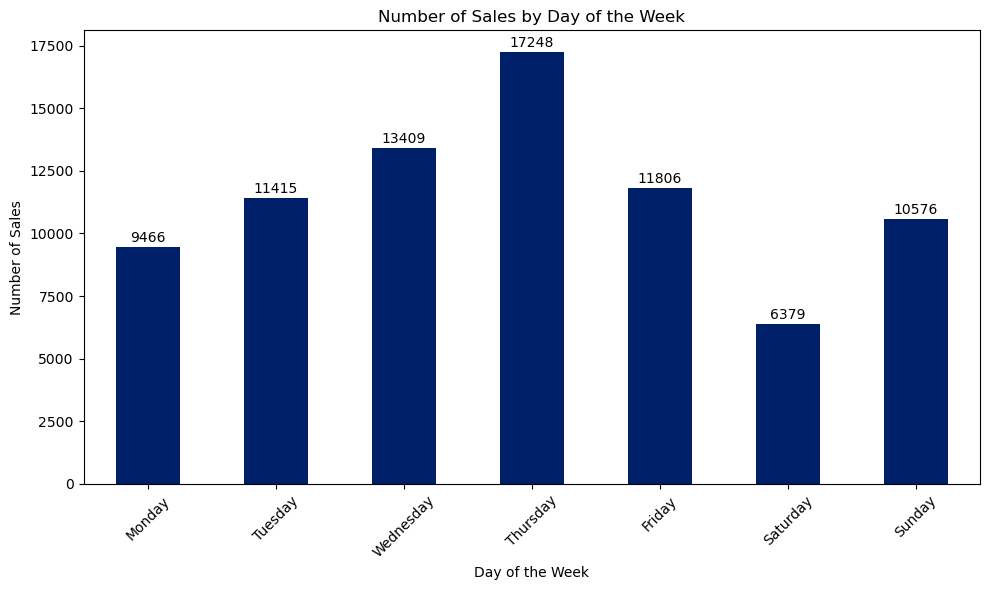

In [291]:
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

sales_by_day = df.groupby('labelling_day_of_week')['sold'].sum()

sales_by_day.index = sales_by_day.index.map(day_mapping)

plt.figure(figsize=(10, 6))
sales_by_day.plot(kind='bar', color='#001F69')

plt.title('Number of Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sales')

for i, value in enumerate(sales_by_day):
    plt.text(i, value + 200, str(value), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In the previous bar charts, we can observe that:
- The quantity of products nearing expiration and with a discount applied is higher in Medium and __Small__ stores, with __Large__ stores being the least represented in the dataset.
- There is a greater dominance of these products in the Center region.
- The day of the week with the highest number of discounted labeled products is __Thursday__.

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.6. Outliers
    
</div>

In Section 2, we concluded that there are outliers for the variables `Profit (€)` and `selling_square_ft`, and several numeric variables were not analyzed at that moment because they were not categorized as such or had not yet been created.

#### 3.2.6.1 Analysis of skewness and kurtosis

In [199]:
df.skew(numeric_only=True)

oldpvp                      5.145517
weight (g)                  0.524855
Margin (%)                 -0.371813
Profit (€)                  1.197624
perc_expiring_sku           0.207792
sold                       -0.148200
selling_square_ft           1.176166
new_pvp                     1.381423
discount                    3.376210
labelling_days_until_exp    6.855502
skus_per_ft                 6.398776
skus_per_store              2.182509
unique_skus_brand          -0.954862
product_cost                1.401147
dtype: float64

Upon performing the skewness analysis again, it is observed that:
- `High Skewness (greater than |1.0|)`: oldpvp, Profit (€), selling_square_ft, new_pvp , discount, labelling_days_until_exp, skus_per_ft,skus_per_store e product_cost
- `Moderate Skewness (between |0.5| and |1.0|)`: weight (g) and unique_skus_brand

In [201]:
df.kurtosis(numeric_only=True)

oldpvp                      260.938506
weight (g)                    2.307579
Margin (%)                   -1.262098
Profit (€)                    3.816302
perc_expiring_sku            -0.420163
sold                         -1.978063
selling_square_ft             0.905701
new_pvp                       9.464847
discount                     24.742544
labelling_days_until_exp     71.062888
skus_per_ft                  41.785595
skus_per_store                6.518503
unique_skus_brand            -1.045601
product_cost                 10.355974
dtype: float64

Regarding kurtosis, the suspicion of the presence of outliers in the variables: oldpvp, Profit (€), new_pvp, discount, labelling_days_until_exp, skus_per_ft, skus_per_store, and product_cost is reinforced due to the high value (greater than 3.0).

#### 3.2.6.2 Visual Analysis of Outliers

In [293]:
def hist_boxplot_display(df, columns):
    for coluna in columns:
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))  

        sns.histplot(df[coluna].dropna(), bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f"Histogram - {coluna}")

        sns.boxplot(x=df[coluna].dropna(), ax=axes[1])
        axes[1].set_title(f"Boxplot - {coluna}")

        sns.kdeplot(df[coluna].dropna(), ax=axes[2], fill=True)
        axes[2].set_title(f"KDE - {coluna}")

        plt.tight_layout()
        plt.show()

In [295]:
columns = ['oldpvp', 'Profit (€)', 'selling_square_ft',
           'new_pvp' , 'discount', 'labelling_days_until_exp',
           'skus_per_ft','skus_per_store','weight (g)', 'unique_skus_brand','product_cost']

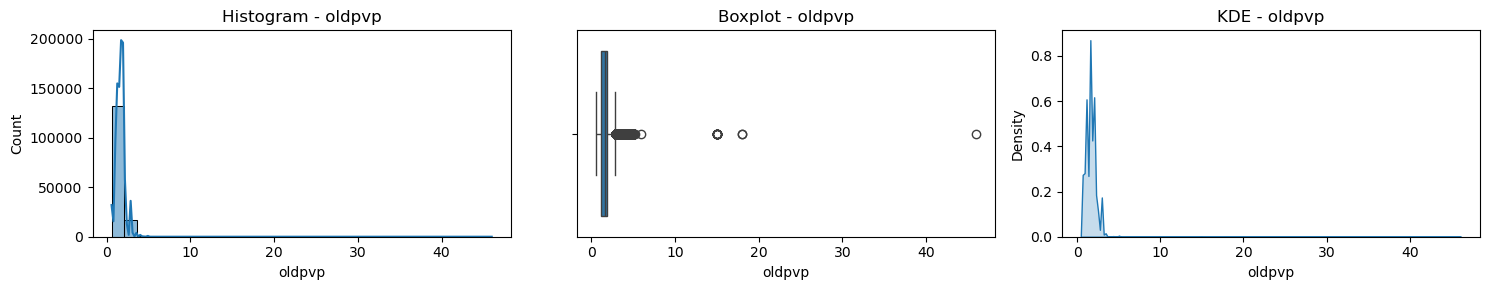

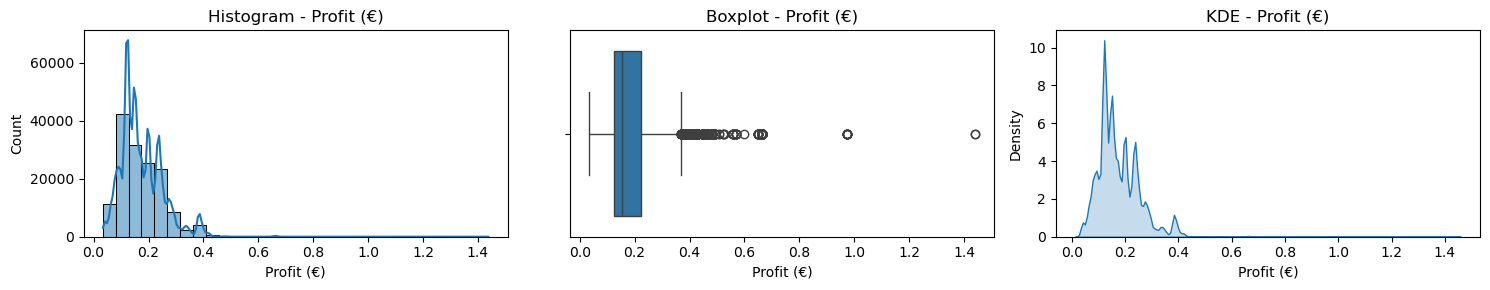

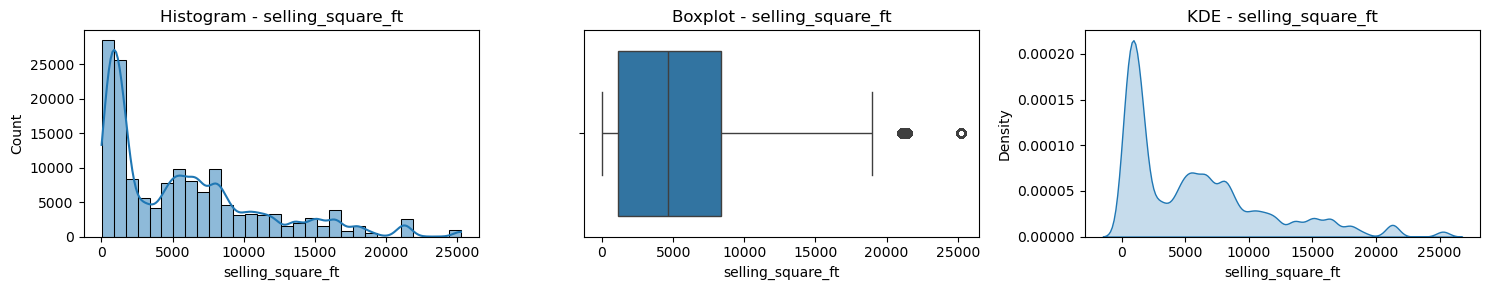

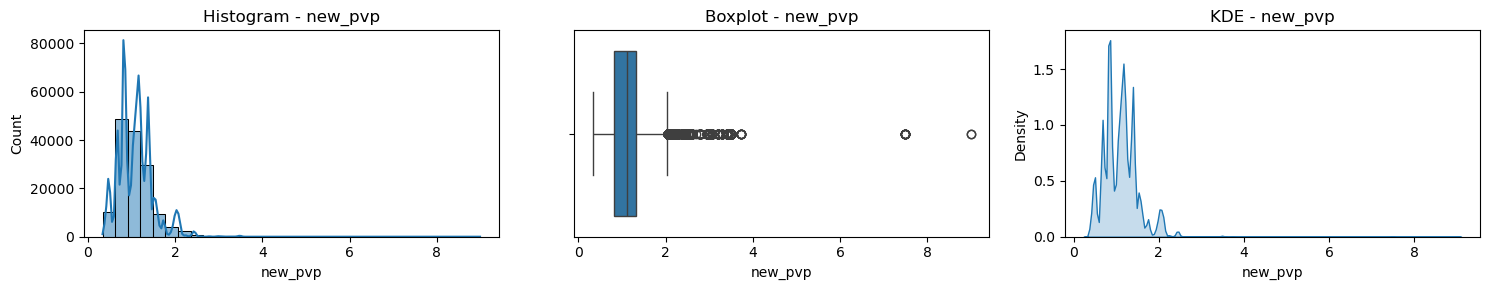

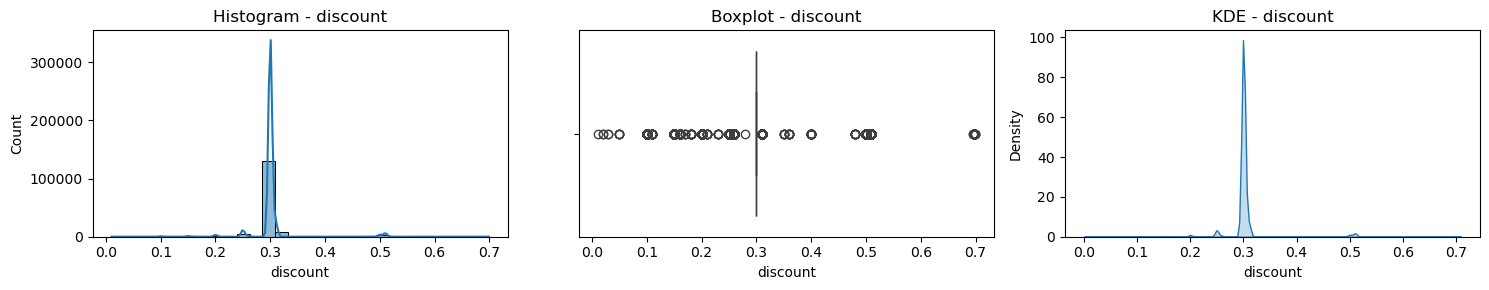

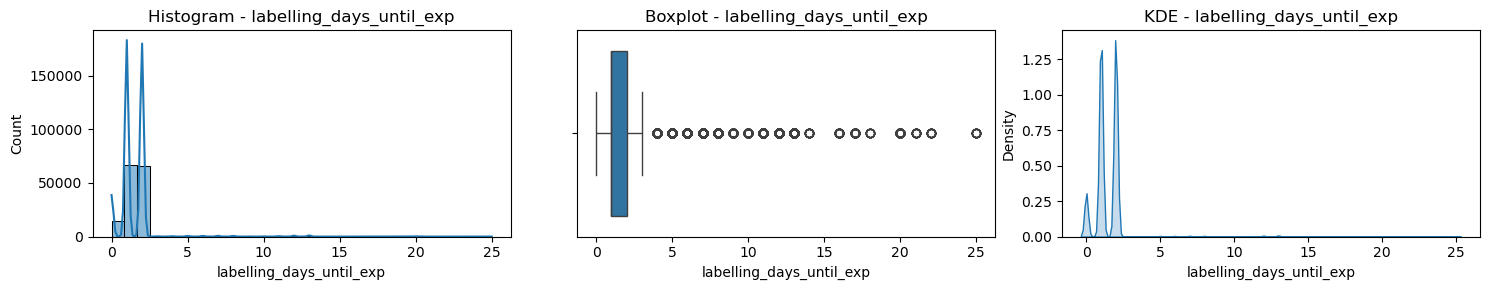

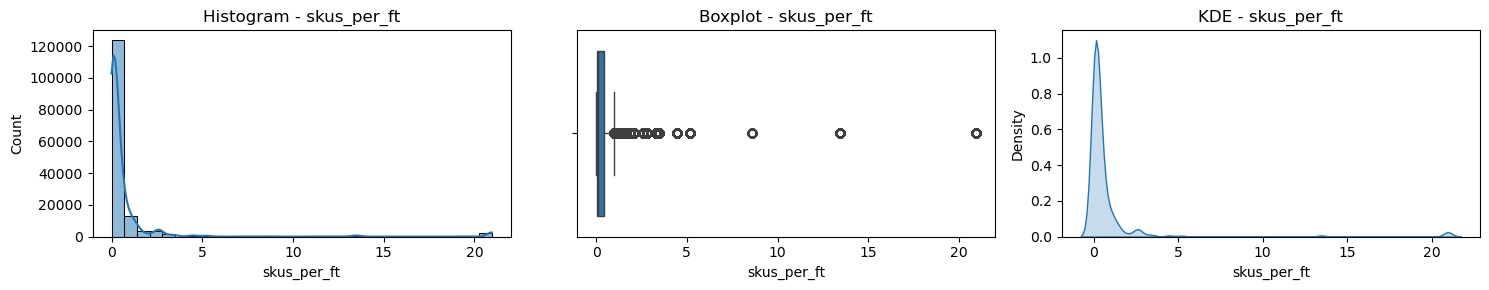

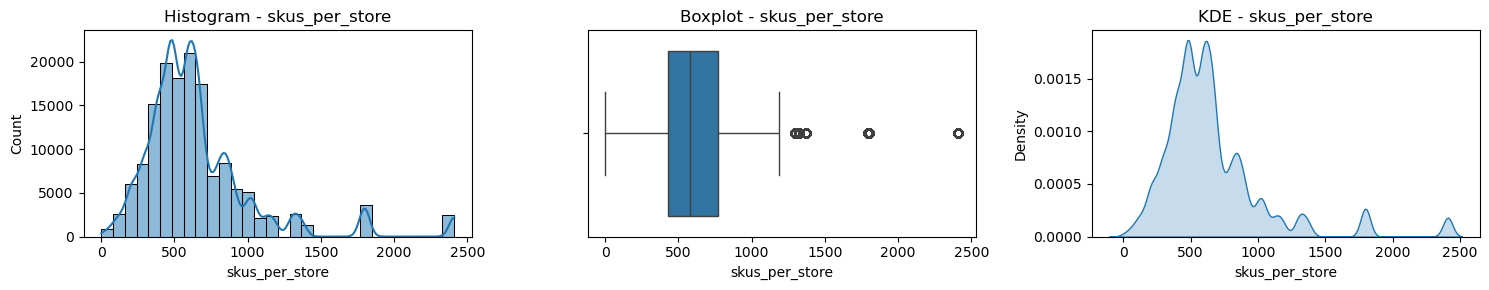

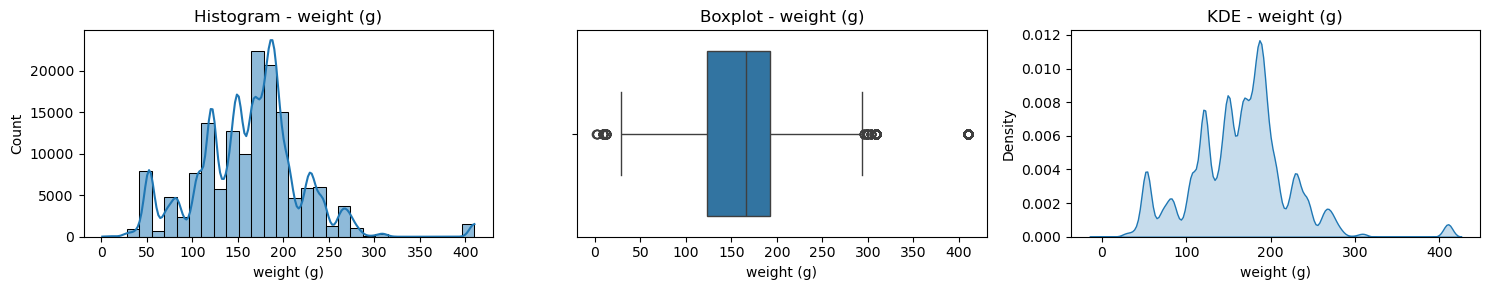

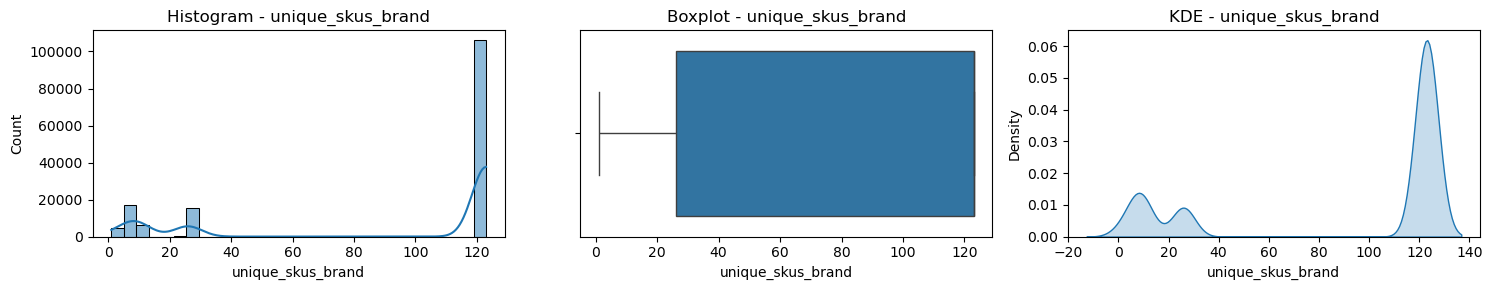

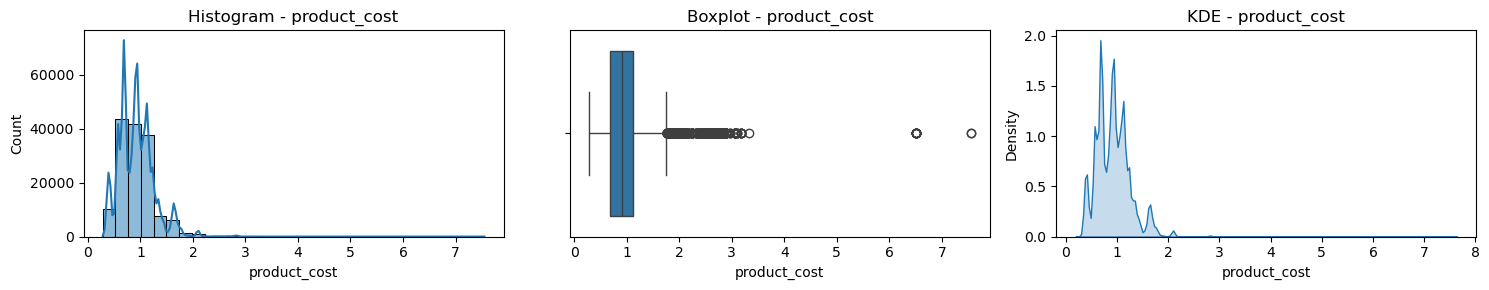

In [297]:
hist_boxplot_display(df, columns)

Outliers are observed only in the variable 'oldpvp' above 10, and these will be removed.
Due to the high density of points in the quartiles of the boxplot, the median and the quartiles adjust to this concentration, causing legitimate values that are farther away to appear as outliers when they are not truly outliers.


In [298]:
df_no_outliers = df.drop(df[df["oldpvp"] > 10].index)

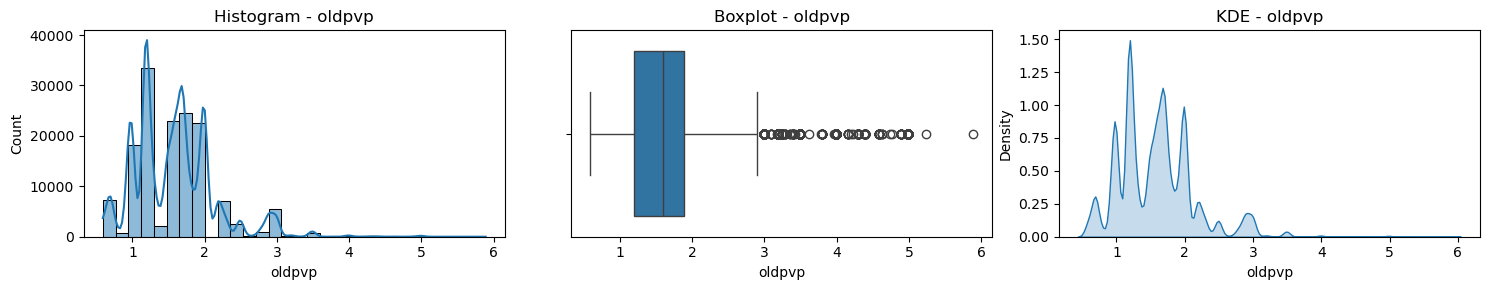

In [299]:
hist_boxplot_display(df_no_outliers,['oldpvp'])

<div class="alert alert-block alert-info">

<a id='new'></a>

### 3.2.7. Scalling
    
</div>

Since the data does not exhibit a uniform distribution, it would not be a good practice to identify outliers, as certain records might appear abnormal simply due to the high concentration of other data. For this reason, before analyzing what constitutes an outlier or not, the data will first be scaled, and only then will the outliers be identified.

In [301]:
def scale_data_log(df, columns):
    df_scaled = df.copy()

    for column in columns:
        df_scaled[f"{column}_log_scaled"] = np.log1p(df_scaled[column])
    
    return df_scaled

In [302]:
def apply_log_scaling(df, columns, epsilon=0.000001):
    df1 = df.copy()
    for col in columns:
        if col in df1.columns:
            df1[col] =(df1[col] + epsilon)
    return df1

In [303]:
numerical_columns = df.select_dtypes(include='number').columns.tolist()

In [306]:
df_no_outliers=apply_log_scaling(df_no_outliers,['labelling_days_until_exp'])

In [307]:
columns = df_no_outliers.select_dtypes(include='number').columns.tolist()
df_scaled = scale_data_log(df_no_outliers, columns)

In [308]:
columns = df_scaled.select_dtypes(include='number').columns.tolist()

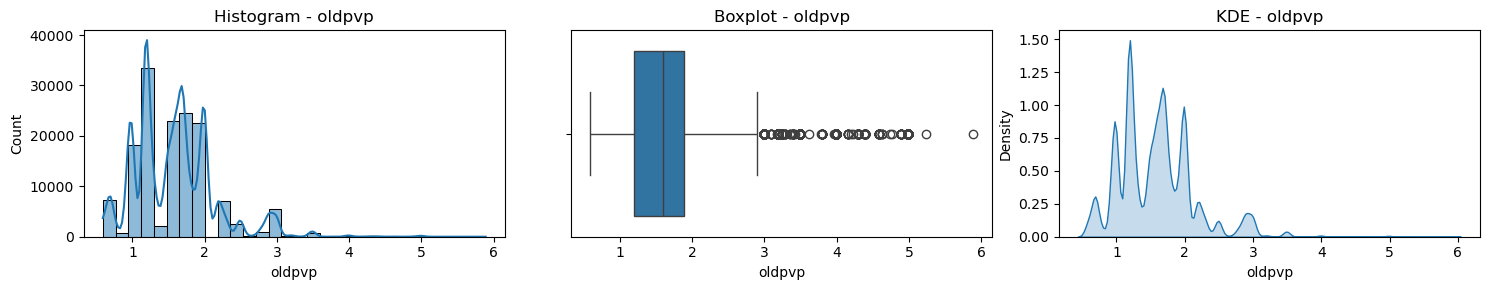

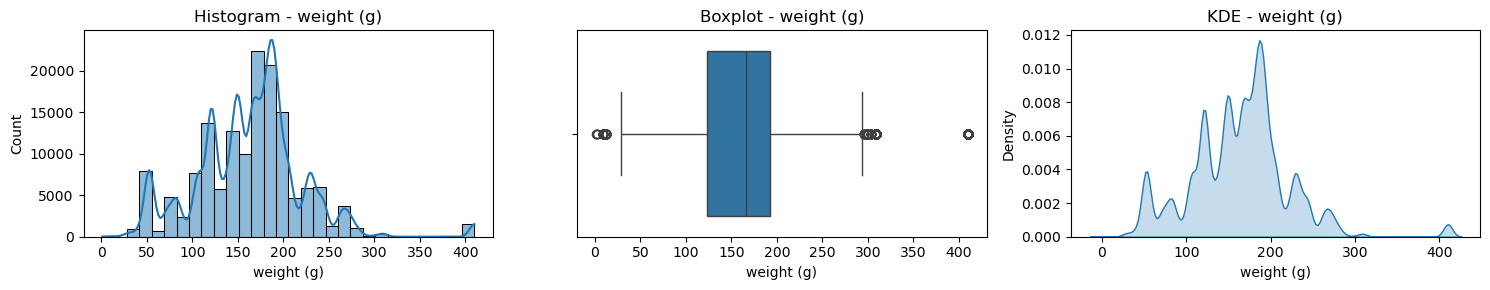

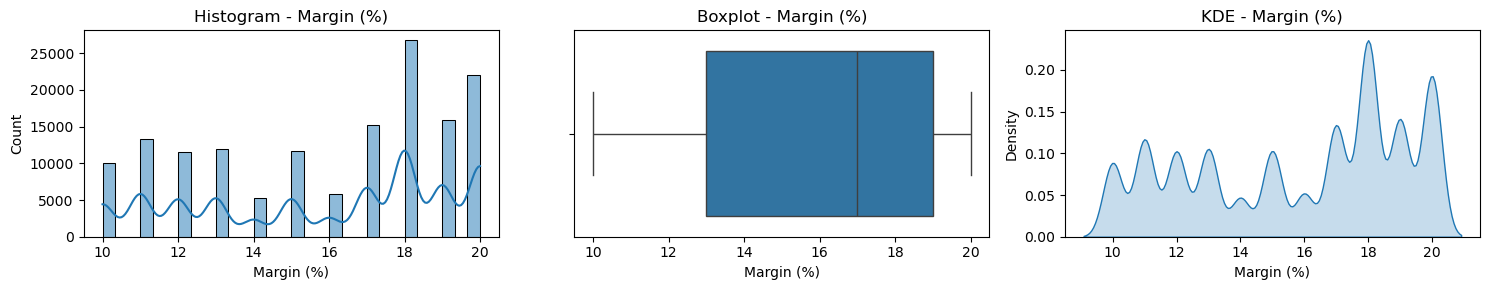

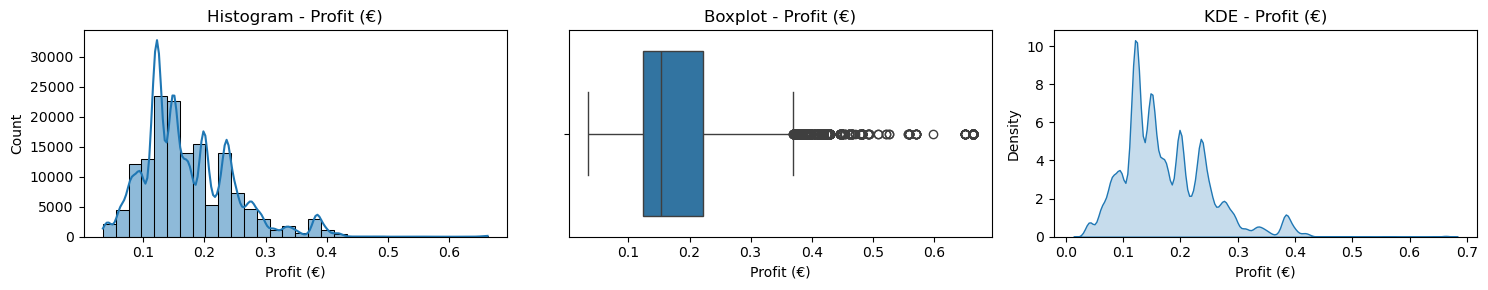

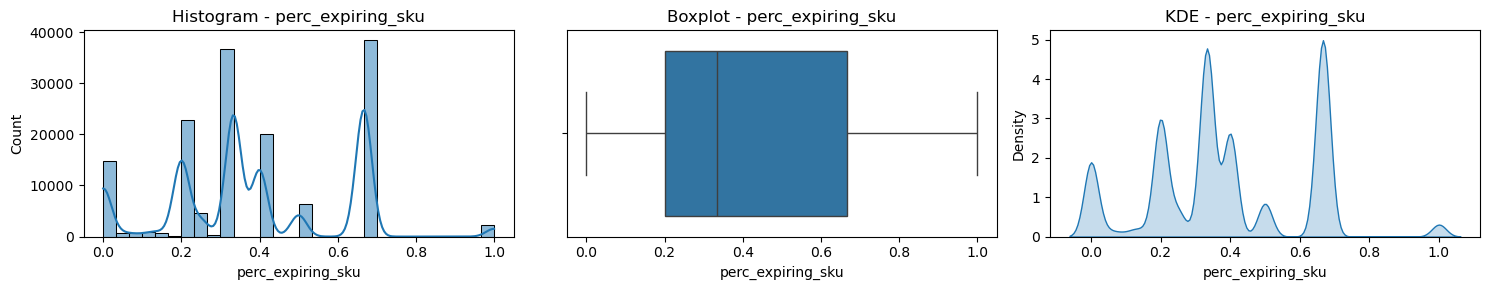

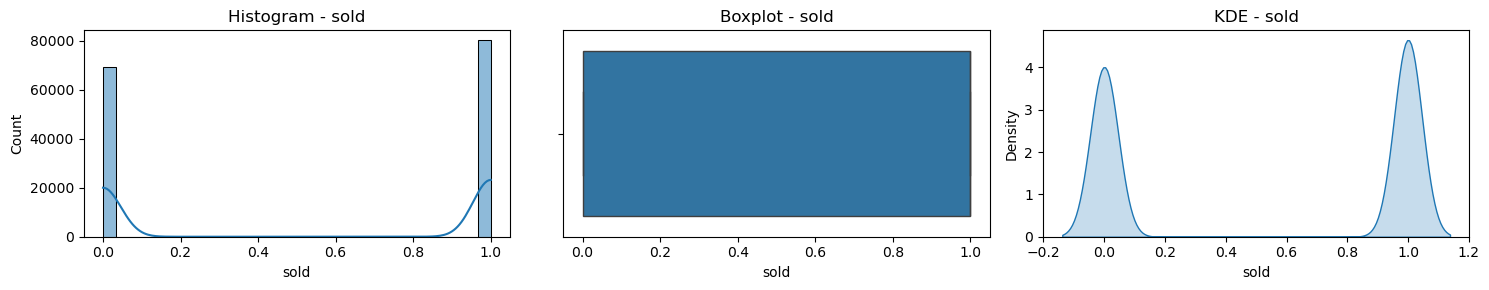

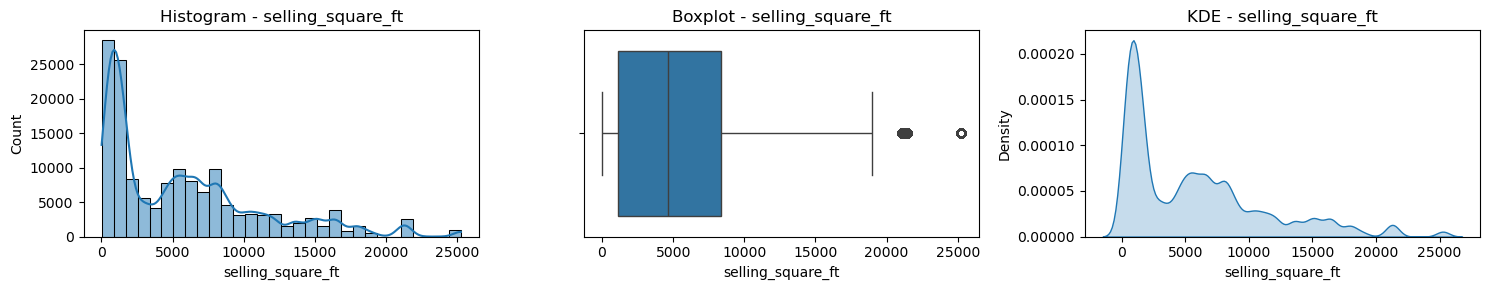

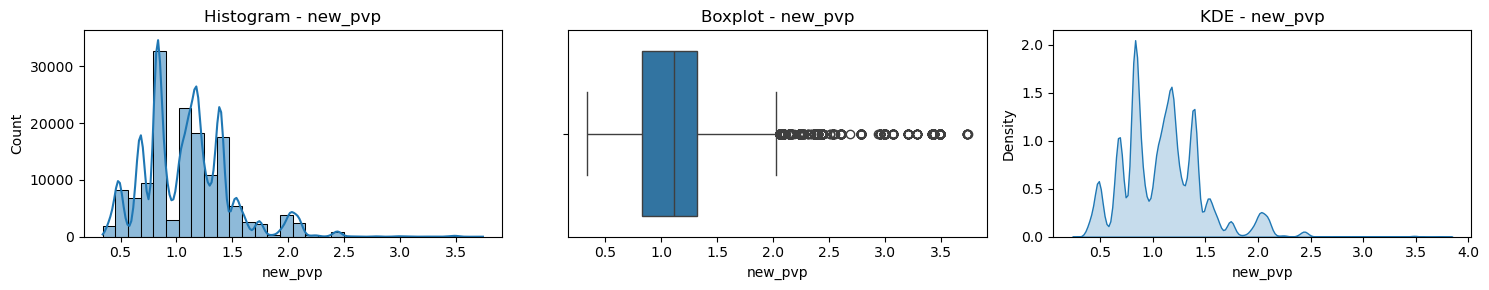

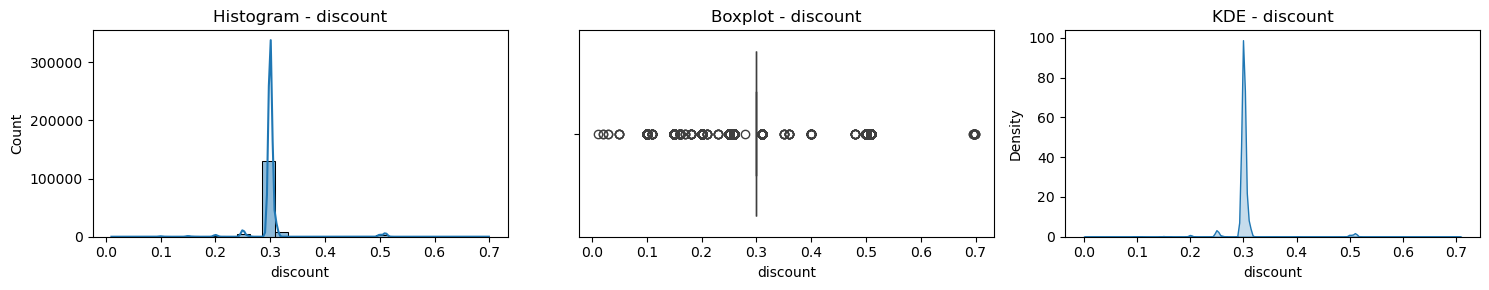

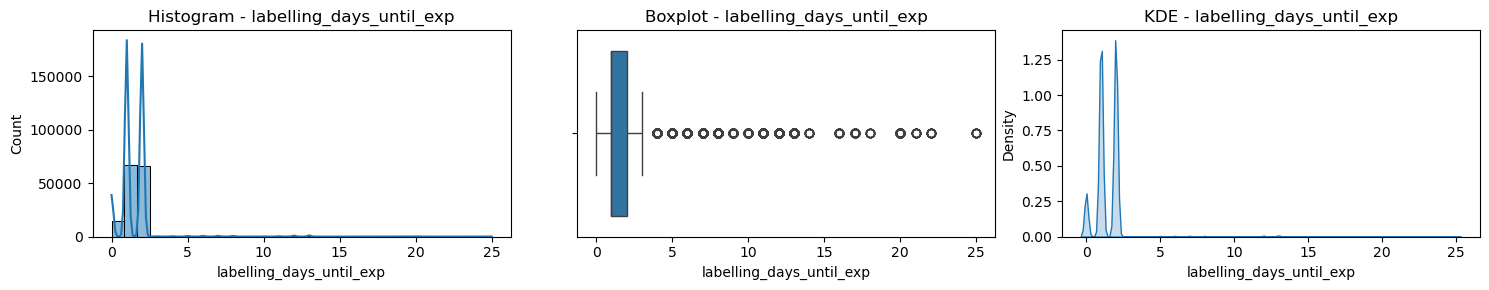

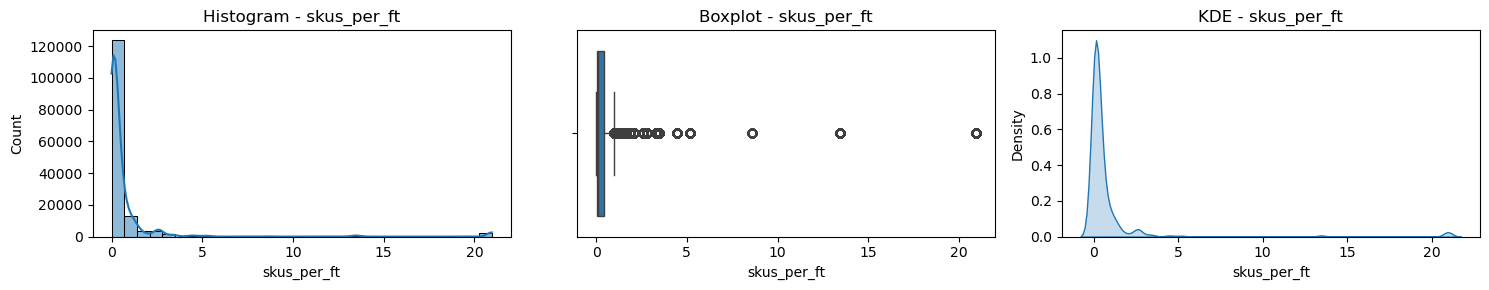

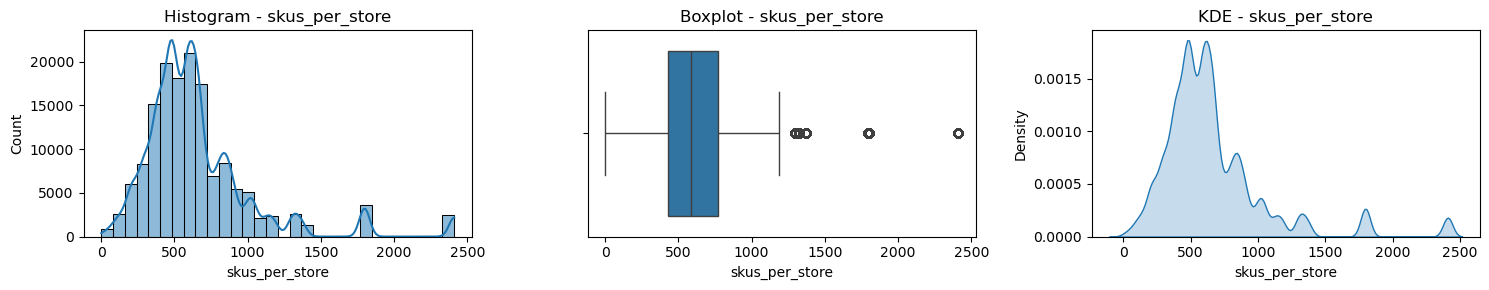

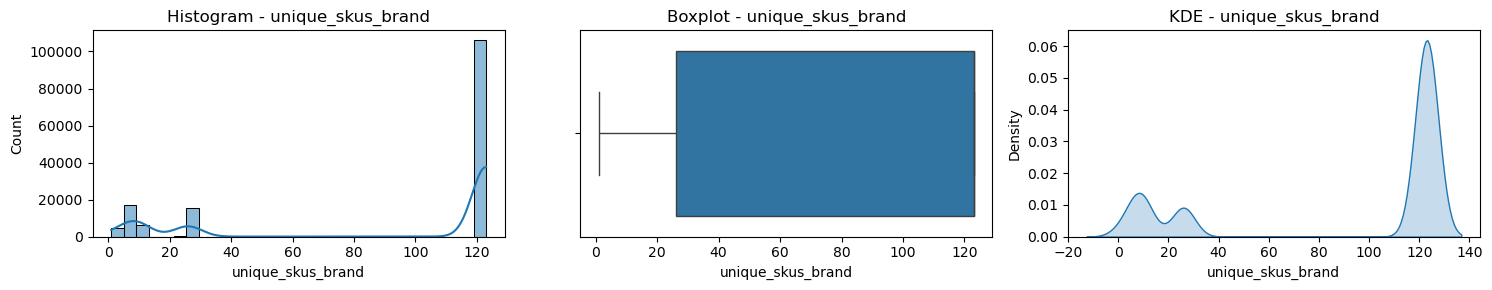

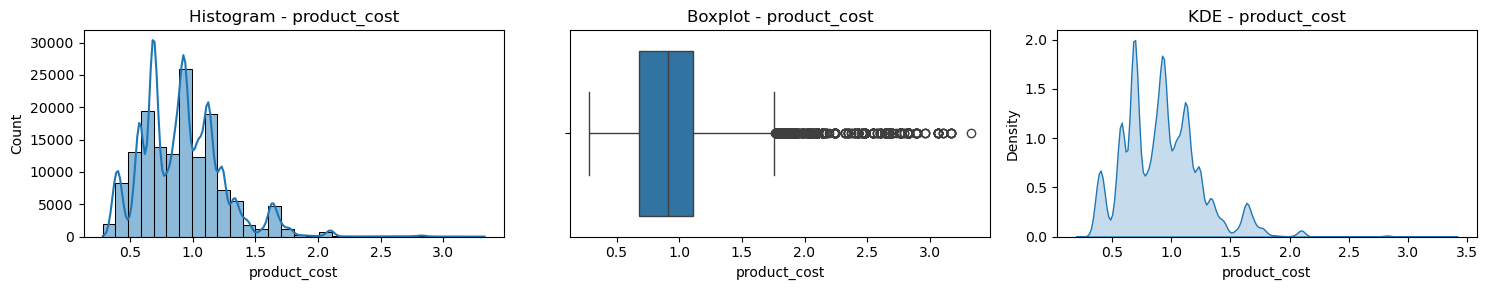

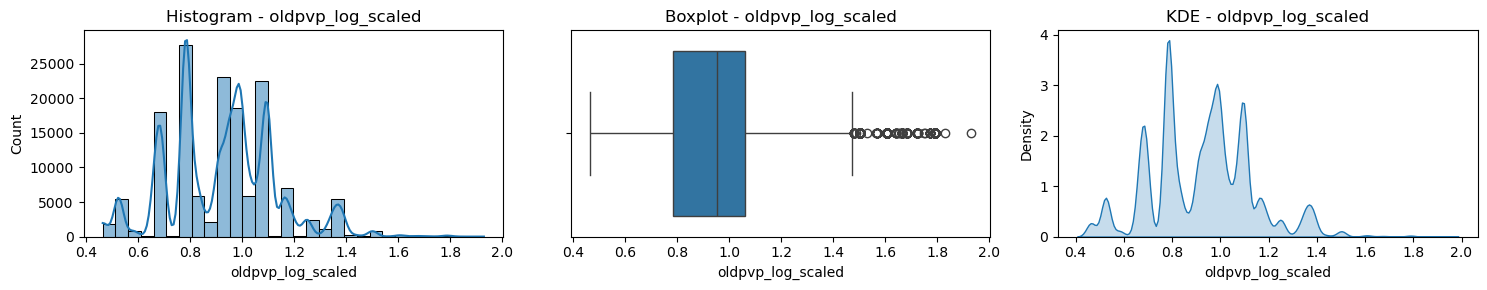

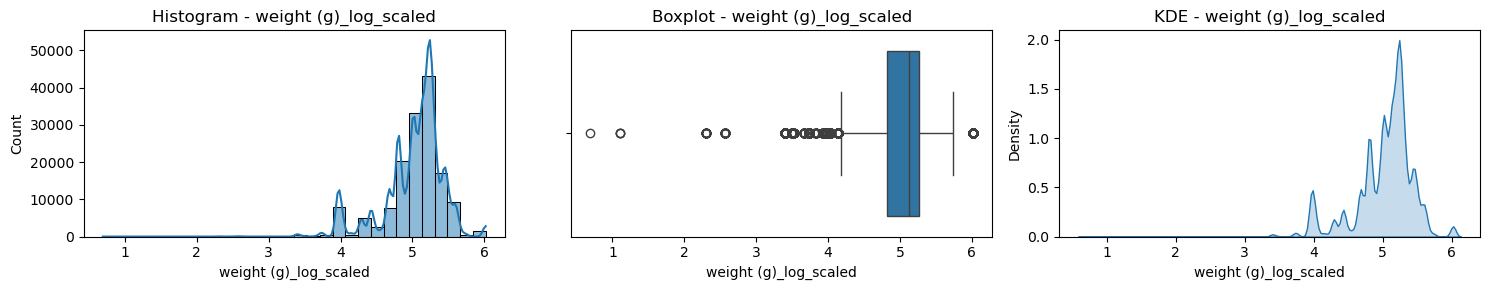

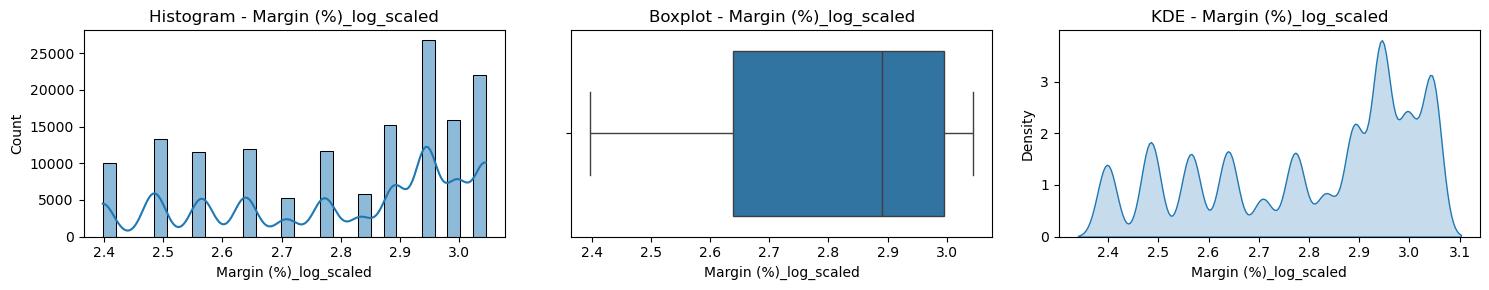

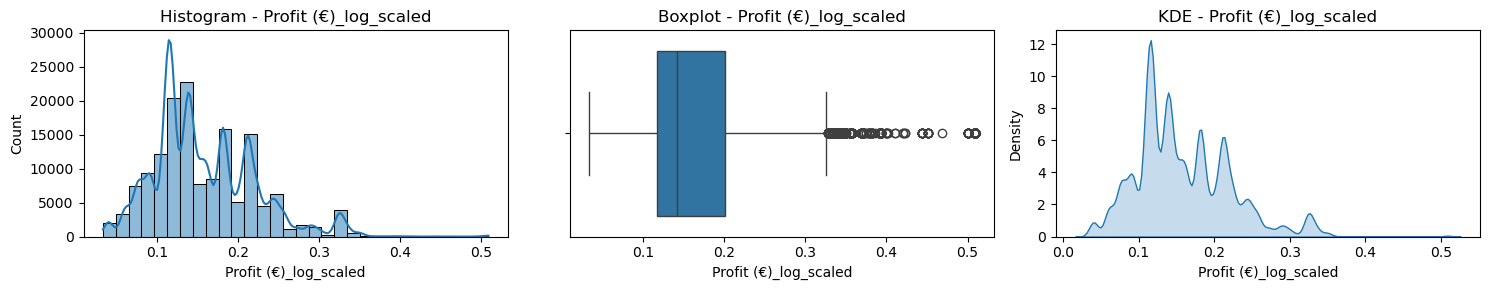

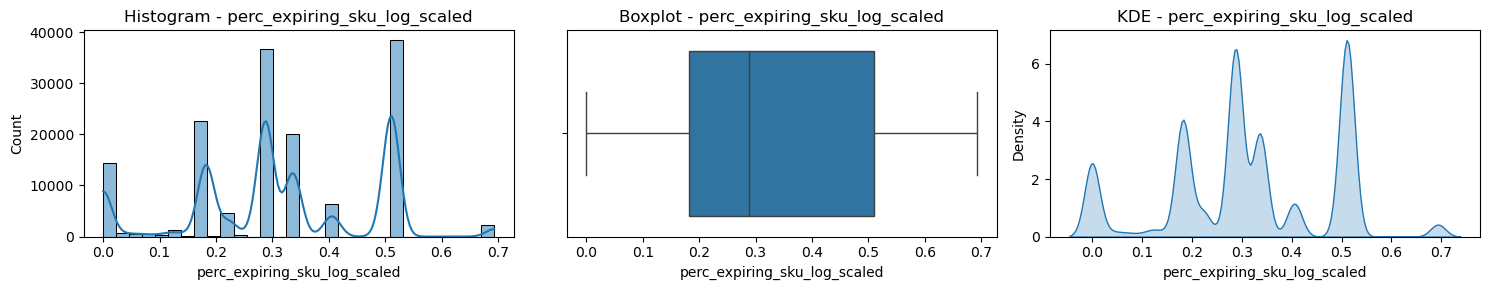

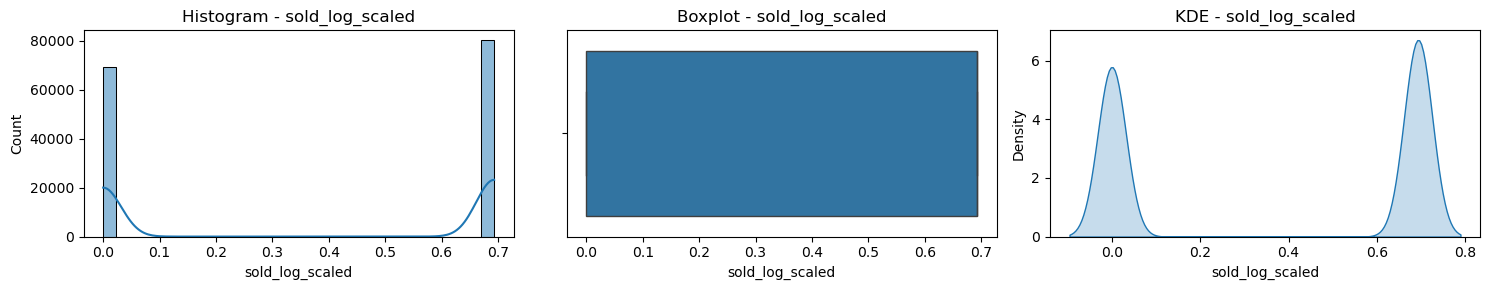

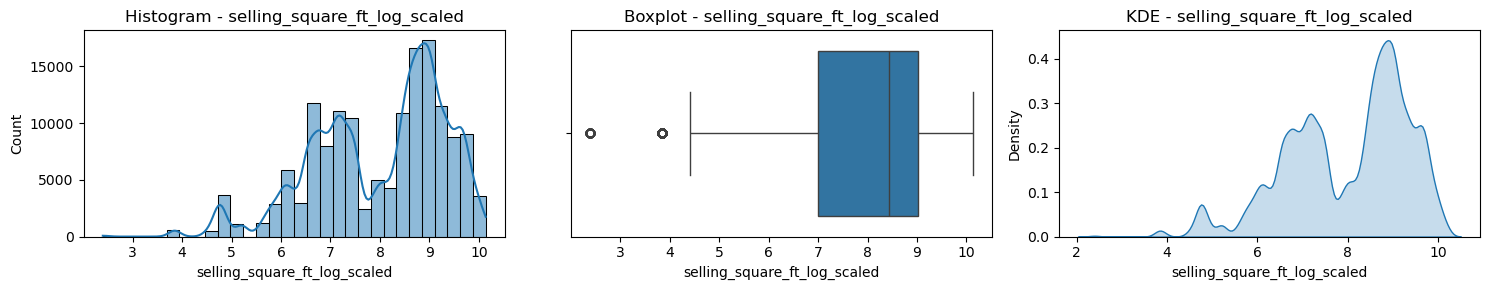

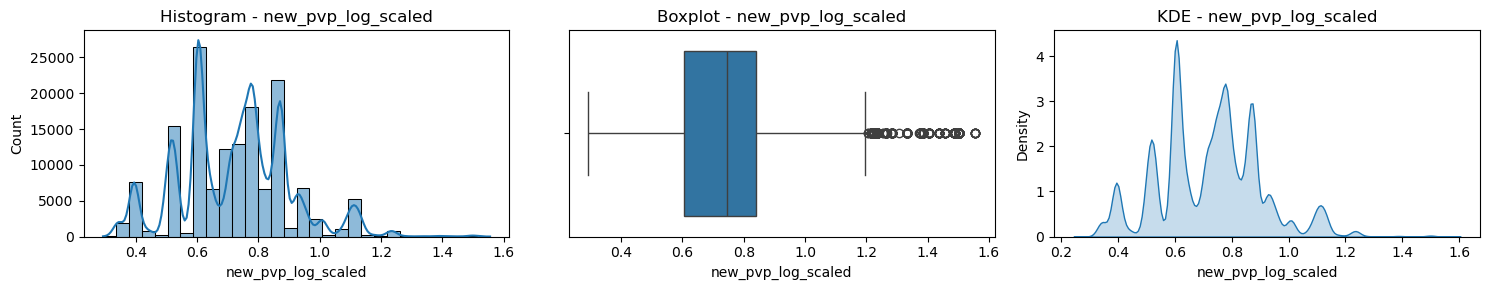

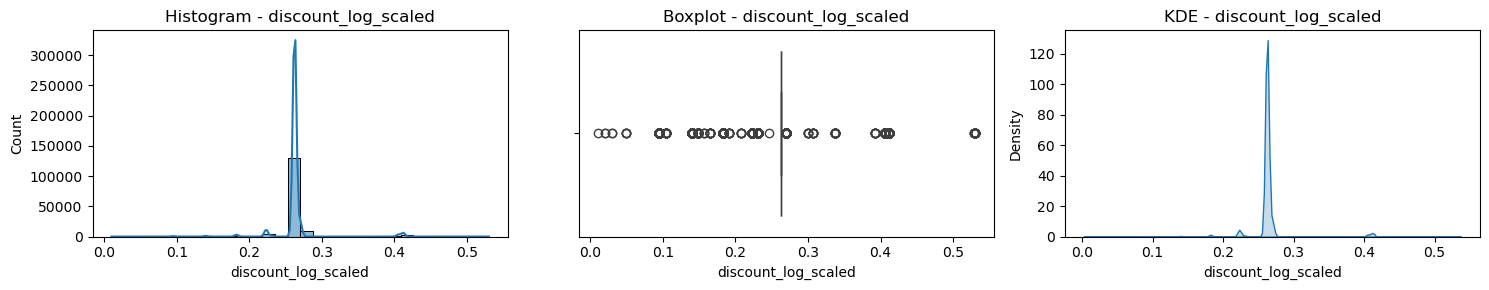

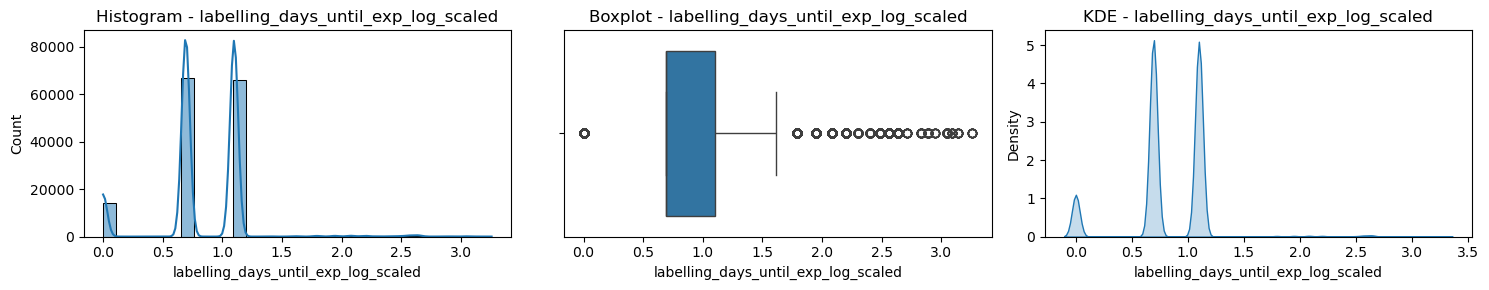

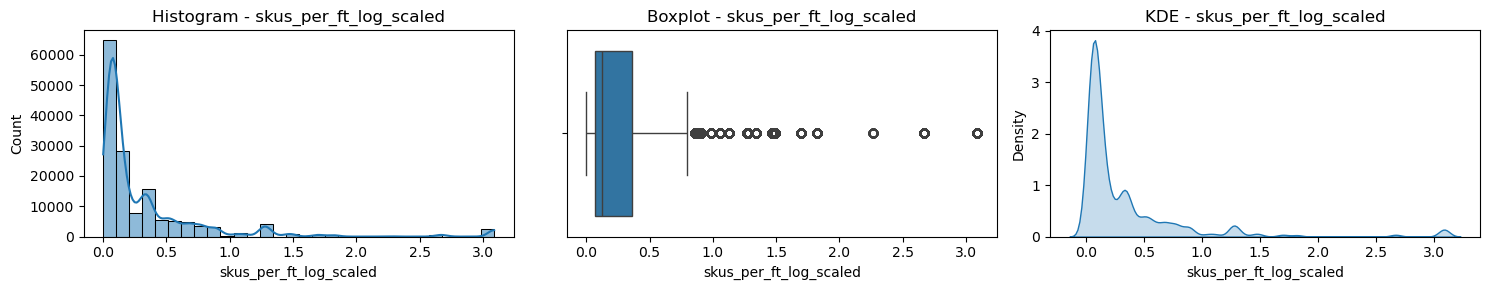

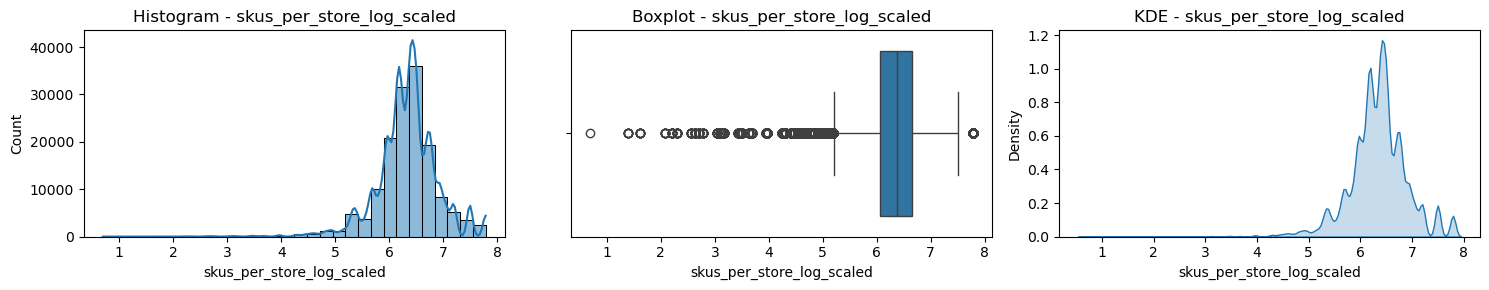

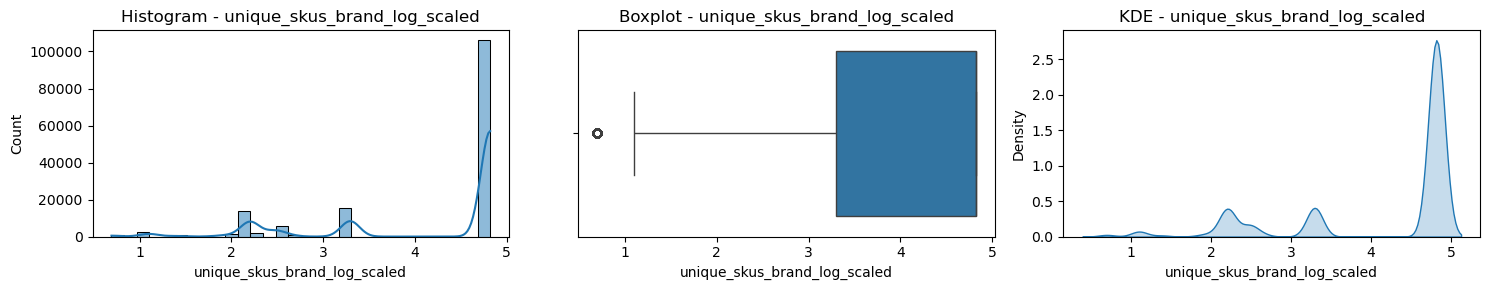

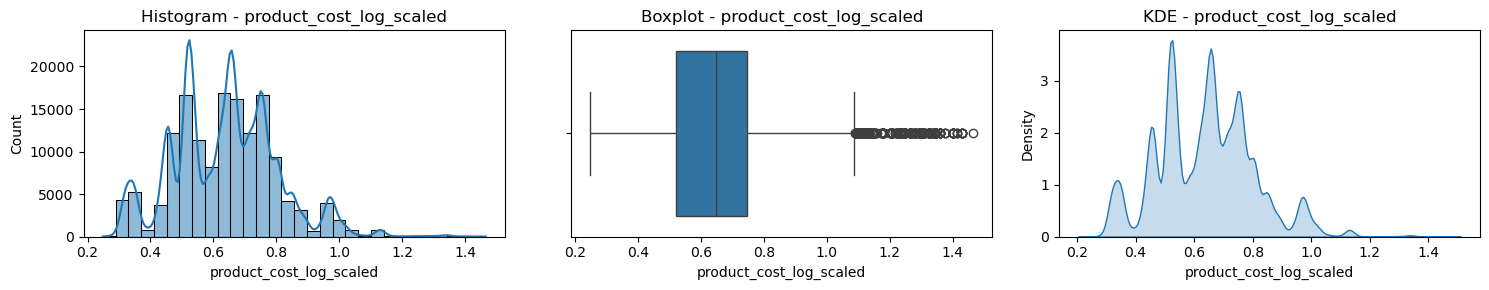

In [309]:
hist_boxplot_display(df_scaled, columns)

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 4. Feature Selection
</a>
    
</div>

In this section, after completing the dataset preparation steps, it is necessary to perform the selection of variables that have predictive power for the target variable, i.e., whether the product will be sold or not.

In [319]:
df_most_recent= df_no_outliers.copy()

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 4.1. Data Preparation: Train-Test Split
    
</div> 

Before selecting variables for the prediction model, it is necessary to perform the separation of the training and testing data. The separation method can be carried out using several techniques, and in this case study, we will use `K-Fold Cross-Validation`, specifically the Stratified version. This ensures that the class distribution is approximately the same in each "fold" (division).

The initialization hyperparameters used for the `K-Fold Cross-Validation` model are as follows:
- `Number of splits` (n_splits) = 7
- `Reproducibility` (random_state = 99)
- `Shuffle` (shuffle = True)

In [323]:
skf = StratifiedKFold(n_splits = 7, random_state = 99, shuffle = True)

Next, the independent variables (X) and target variable (y) are separated into two distinct dataframes:

In [325]:
X = df_most_recent.drop('sold', axis = 1)
y = df_most_recent['sold'].copy()

Finally, the data is split into __training data__ (90%) and __testing data__ (10%): 

In [327]:
X, X_test, y, y_test = train_test_split(X, y,
                                        train_size = 0.9,
                                        random_state = 99,
                                        stratify = y)

For the next steps, the data will be treated as two independent sets: the __training__ set and the __testing__ set.

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 4.2. Feature Selection
    
</div> 

The variable selection for the model will be carried out using the following methods:

- **Chi-Square (Filter Method)** – *Categorical Variables*
- **Variance (Filter Method)** – *Continuous, Ordinal, and Binary Variables*
- **Spearman Correlation (Filter Method)** – *Continuous and Ordinal Variables*
- **Recursive Feature Elimination (RFE) (Wrapper Method)** – *Continuous, Ordinal, and Binary Variables*
- **Lasso Regression (Embedded Method)** – *Continuous and Ordinal Variables*
- **Decision Trees (Embedded Method)** – *Continuous, Ordinal, and Binary Variables*

The feature selection techniques will be applied in the following order:

1. **Variance** – To detect the presence of constant variables.
2. **Spearman Correlation** – To detect correlated variables.
3. **Decision Trees** – To keep only one variable from a group of correlated variables.
4. **RFE** – To iteratively select features, considering subsets of them.
5. **Lasso** – To identify and select the important features in a dataset.

By following this approach, the most relevant variables will be selected for the model, ensuring better performance and reducing the risk of overfitting.

The application of Feature Selection requires the identification and use of specific techniques for each variable type.<br>
 Here is the list of variables under analysis:

|# |Predictor                              | Data Type   |
|--|---------------------------------------|-------------|
|0 |oldpvp                                 | Numerical   |
|1 |weight (g)                             | Numerical   |
|2 |Margin (%)                             | Numerical   |
|3 |Profit (€)                             | Numerical   |
|4 |perc_expiring_sku                      | Numerical   |
|5 |sold ----> __TARGET__         | Binary      |
|6 |type                                   | Categorical |
|7 |selling_square_ft                      | Numerical   |
|8 |new_pvp                                | Numerical   |
|9 |discount                               | Numerical   |
|10|labelling_days_until_exp               | Numerical   |
|11|region                                 | Categorical |
|12|marca_2                                | Categorical |
|13|skus_per_ft                            | Numerical   |
|14|skus_per_store                         | Numerical   |
|15|labelling_day_of_week                  | Categorical |
|16|unique_skus_brand                      | Numerical   |
|17|product_cost                           | Numerical   |

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.1. Categorical Variables -  Chi-Square (Filter Method)

</div>

In order to validate the use of categorical variables, a `Chi-Square` test will be performed to determine which ones should be kept:

In [338]:
def apply_chisquare(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for the model".format(var)
    else:
        result="{0} is NOT IMPORTANT for the Forecast. (Discard {0} from the model)".format(var)
    print(result)

In [340]:
def select_best_cat_features(X,y):
    count = 1
    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        X_train_cat = X_train[['type','region','labelling_day_of_week','marca_2']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)
        count+=1

In [342]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
type is IMPORTANT for the model
region is IMPORTANT for the model
labelling_day_of_week is IMPORTANT for the model
marca_2 is IMPORTANT for the model
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
type is IMPORTANT for the model
region is IMPORTANT for the model
labelling_day_of_week is IMPORTANT for the model
marca_2 is IMPORTANT for the model
_________________________________________________________________________________________________

                                     SPLIT 3 

__What can we conclude?__

| Variable | Chi-Square | What to do?|
| --- | --- | --- |
| type | 10 YES | Keep |
| region | 10 YES | Keep |
| labelling_day_of_week | 10 YES | Keep |
| marca_2 | 10 YES | Keep |

It is concluded that all the categorical variables in the analysis should be kept.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.2. Numerical Variables -  Variance (Filter Method)

</div>

The variance of the variables will be studied at this stage to understand which ones are constant or nearly constant, and thus not useful for the prediction model:<br>

In [350]:
def apply_variance(X_train):
    variances = X_train.var(numeric_only=True)

    print("Variance by variable (5 decimal places format):")
    print(variances.apply(lambda x: f"{x:.5f}"))

    return variances

In [352]:
def select_features_variance(X, y):
    results = []
    count = 1
    for train_index, val_index in skf.split(X, y):
        X_train = X.iloc[train_index]

        print('_________________________________________________________________________________________________\n')
        print(f'                                     SPLIT {count}                                    ')
        print('_________________________________________________________________________________________________')

        variances = apply_variance(X_train)
        results.append(variances)
        count += 1
    summary_df = pd.DataFrame(results).mean().reset_index()
    summary_df.columns = ["Variable", "Mean Variance"]
    summary_df["Mean Variance"] = summary_df["Mean Variance"].apply(lambda x: f"{x:.5f}")

    return summary_df


In [354]:
summary = select_features_variance(X, y)
print(summary)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Variance by variable (5 decimal places format):
oldpvp                             0.30534
weight (g)                      3326.56073
Margin (%)                        10.92776
Profit (€)                         0.00571
perc_expiring_sku                  0.04949
selling_square_ft           29712828.17834
new_pvp                            0.15054
discount                           0.00140
labelling_days_until_exp           1.75210
skus_per_ft                        7.88335
skus_per_store                148370.84467
unique_skus_brand               2460.79425
product_cost                       0.10560
dtype: object
_________________________________________________________________________________________________

  

__What can we conclude?__

- **Disregard variables with low variance (below the threshold of 0.01):** the variables `discount` and `Profit (€)`.

- **Variables with high dispersion**, such as `weight (g)`, `selling_square_ft`,`skus_per_store` and `unique_skus_brand`, will be kept and analyzed in future steps to detect the existence of a strong correlation with the target variable and determine whether they should be retained. If they remain, they will also be normalized.


In [358]:
X = X.drop(['Profit (€)', 'discount'], axis = 1)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.3. Correlation Analysis - Spearman (Filter Method)

</div>

The redundancy of numerical variables will be analyzed using Spearman's correlation:

In [362]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [364]:
def apply_correlation(X_train):
    correlation_data = X_train.copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)
    cor_heatmap(matrix)

In [366]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        apply_correlation(X_train)
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


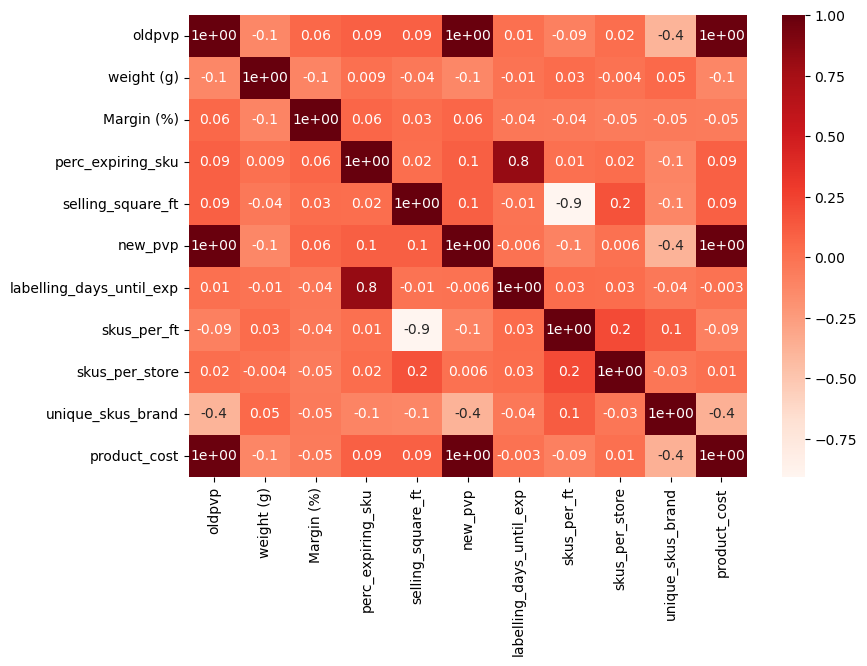

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


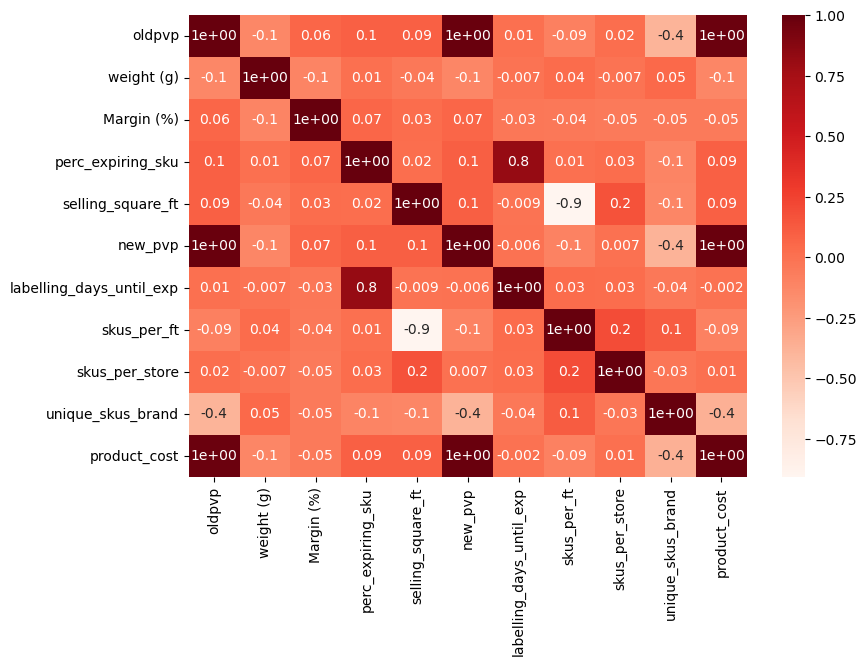

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


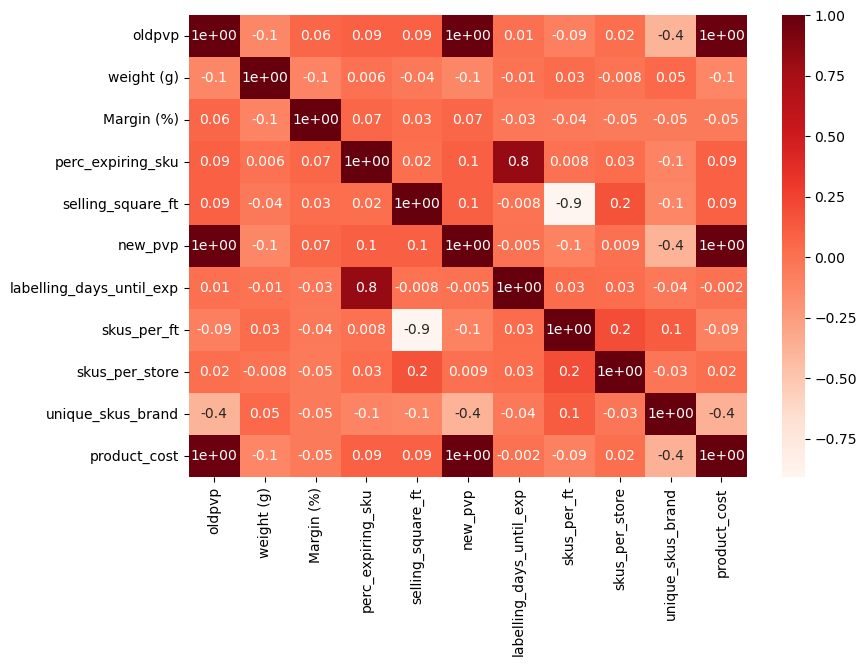

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


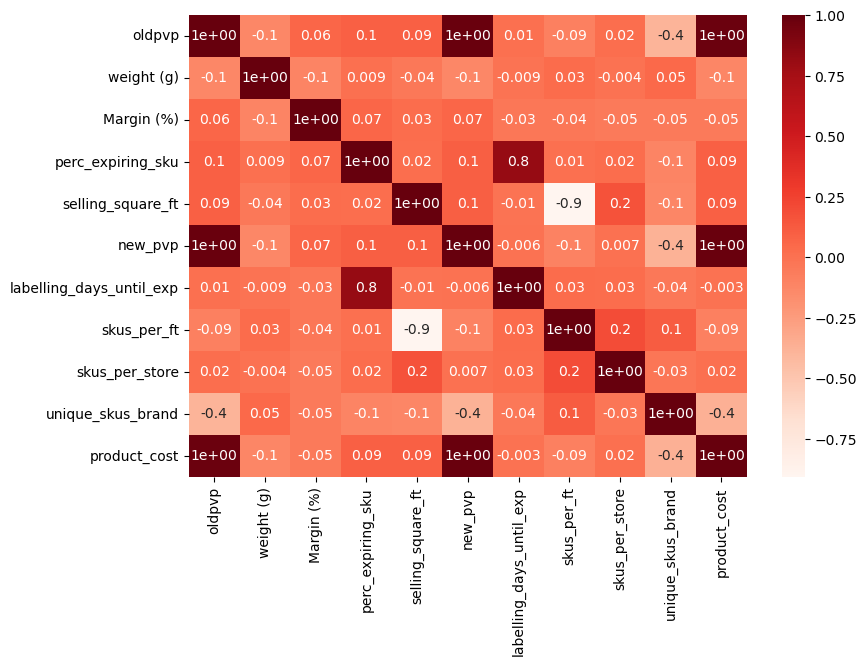

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


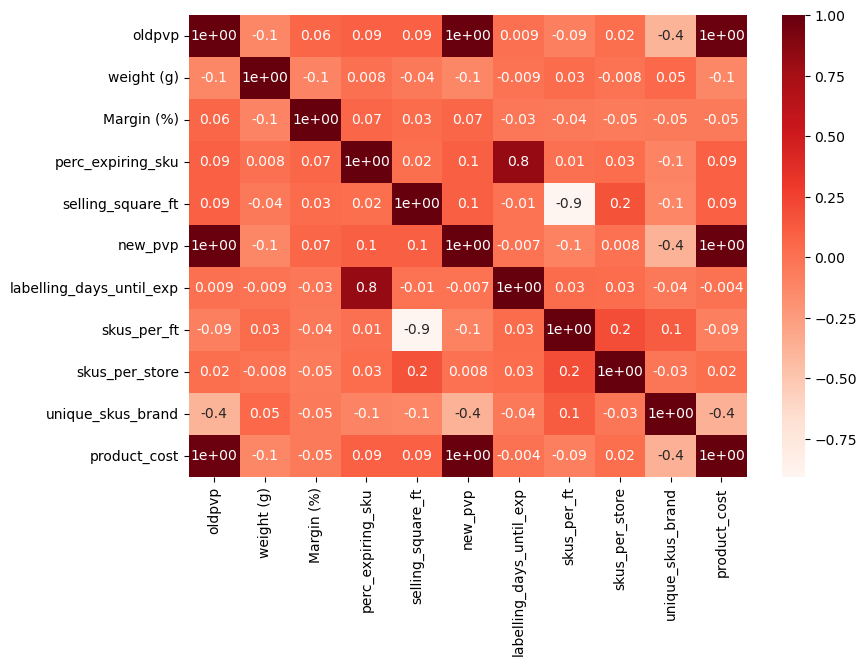

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________


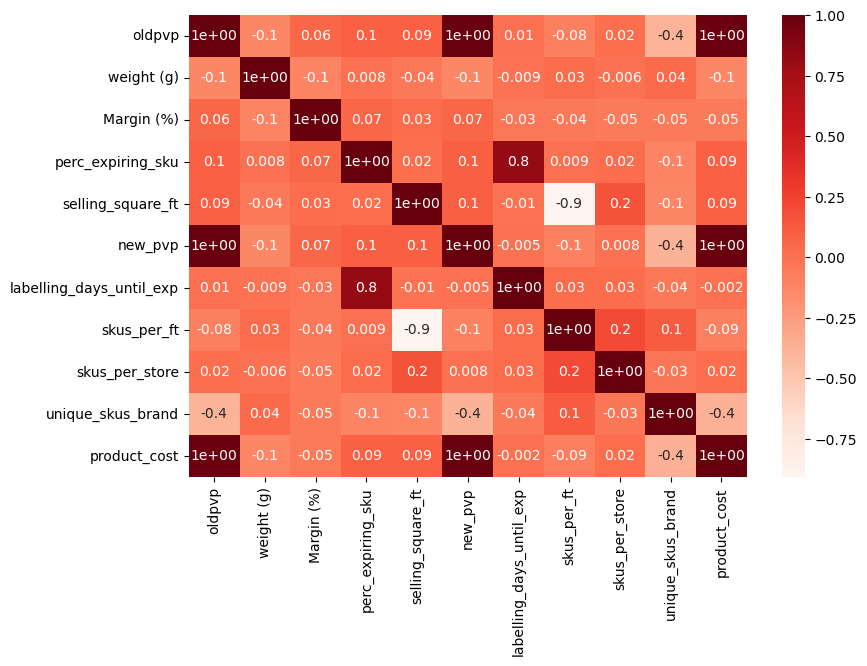

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________


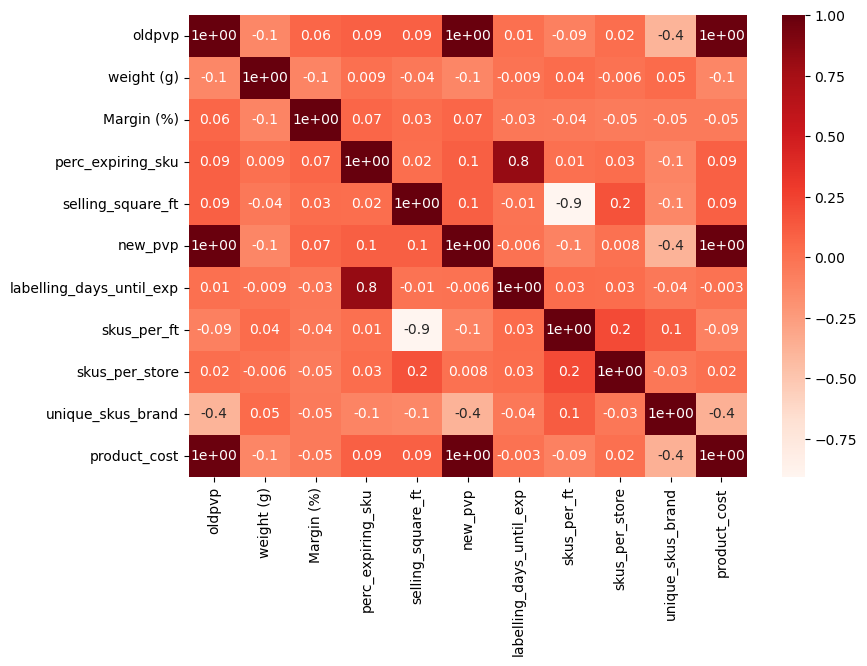

In [368]:
redundant_features(X, y)

__Redundant Variables - Spearman's Correlation (Correlation greater than |0.8|)__ 

| Group                               | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 | Split 6 | Split 7 | Split 8 | Split 9 | Split 10 |
| ------------------------------------------ | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | -------- |
| `oldpvp` vs `new_pvp` vs `product_cost`   | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__ | __1.0__  |
| `selling_square_ft` vs `skus_per_ft`| -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9     | -0.9  |
| `perc_expiring_sku` vs `labelling_days_until_exp` | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8     | 0.8  |



In this case, we can observe a high correlation between the variables:
- `oldpvp` ,`new_pvp` e `product_cost`
- `selling_square_ft` e `skus_per_ft`
- `perc_expiring_sku`e `labelling_days_until_exp`

At this point, it will be important to conclude which variables to keep and which to eliminate within each set, as keeping highly correlated variables can have consequences during modeling:

- **Multicollinearity**: Instability in the model's coefficients and difficulty in interpreting individual effects;
- **Overfitting**: The model may have low generalization capacity;
- **Redundancy**: Similar variables add complexity without improving model performance.
- **Difficulty in estimating coefficients**: Small variations in the data can lead to large changes in the coefficients.

For this reason, a `Feature Importance` analysis will be performed to determine, among the highly correlated variables, which ones are more/less important, using a __Decision Tree__.

Based on the results obtained, the least relevant variables will be eliminated.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.4. Selection of Correlated Variables - Decision Trees (Embedded Method)

</div>

In [376]:
def plot_importance(variables, name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(3,3))
    ax = imp_features.plot(kind="barh")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title("Feature importance using " + name + " Model")
    ax.bar_label(ax.containers[0], fmt='%.2f', padding=0, fontsize=9, color='black')
       
    plt.show()

In [378]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns) 
    plot_importance(feature_importances, 'DT')

In [380]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        X_train = X_train.drop(['type','region','labelling_day_of_week','marca_2'], axis = 1)
        apply_dt(X_train, y_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


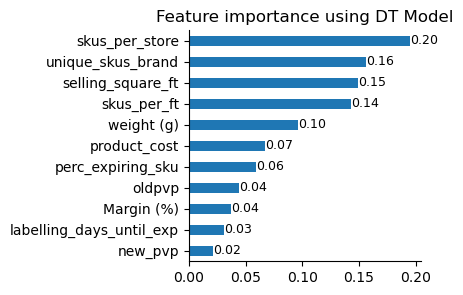

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


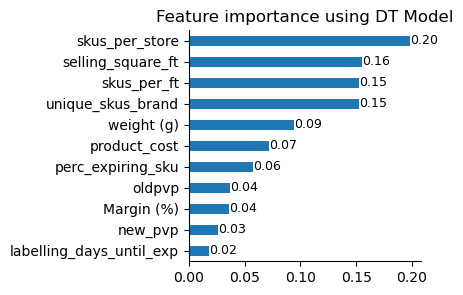

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


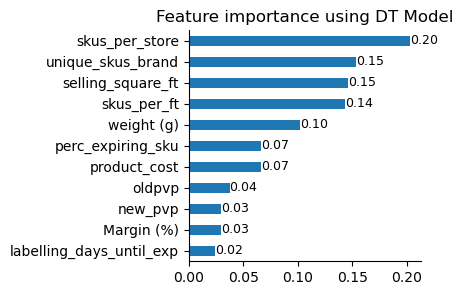

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


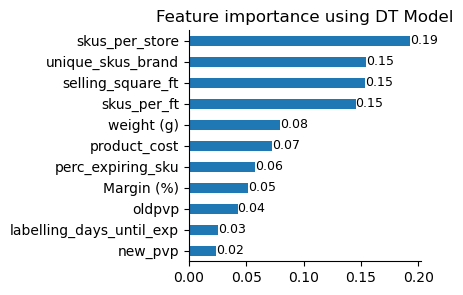

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


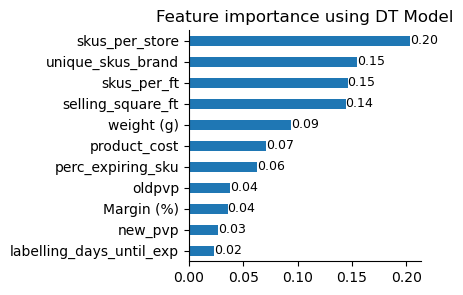

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________


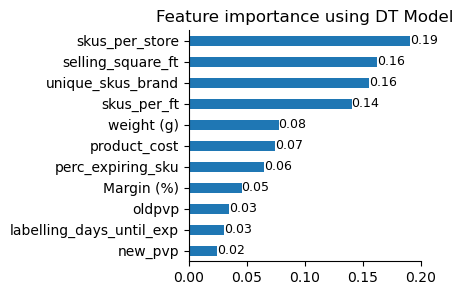

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________


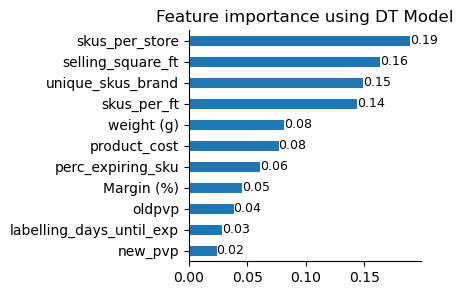

In [382]:
select_best_features_dt(X, y)

As previously noted, the following group of variables has a strong correlation between them: 

- `oldpvp` ,`new_pvp` e `product_cost`
- `selling_square_ft` e `skus_per_ft`
- `perc_expiring_sku` e `labelling_days_unitl_exp`

The presence of a significant correlation between these variables may indicate that they are capturing similar information.
That being said, after performing a feature importance analysis using a Decision Tree, it is concluded that the following variables can be eliminated as they have less importance compared to the highly correlated ones:

- `old_pvp`
- `new_pvp`
- `skus_per_ft`
- `labelling_days_until_exp` 

In [385]:
X = X.drop(['oldpvp','new_pvp','skus_per_ft','labelling_days_until_exp'], axis = 1)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 4.2.5. Variable Selection - Multi-Methods

Finally, the following techniques will be applied: __Lasso Regression__, __Decision Trees__, and __RFE (Recursive Feature Elimination)__ to assess the importance of the remaining numerical variables.<br> In order to apply these methods, data scaling will be necessary. The objective is to identify the 4 (out of 7) most important numerical variables for the model. It is worth noting that logarithmic scaling was applied, as the data, in general, has a very uneven distribution.


#### 4.2.5.1 Recursive Feature Elimination (RFE) (Wrapper Method)

In [390]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 4)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)  
    print(selected_features)

#### 4.2.5.2 Lasso Regression (Embedded Method)

In [393]:
def apply_lasso(X_train, y_train):
    lasso = LogisticRegressionCV(penalty='l1', solver='saga').fit(X_train, y_train)
    coef = pd.Series(abs(lasso.coef_[0]), index = X_train.columns)
    plot_importance(coef,'Lasso')

#### 4.2.5.3 Methods Comparison

In [397]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        
        ########################################### SCALE DATA #################################################### 
        numerical_data = X_train.drop(['type','region','marca_2','labelling_day_of_week'], axis = 1).copy()
        X_train_scaled = np.log1p(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


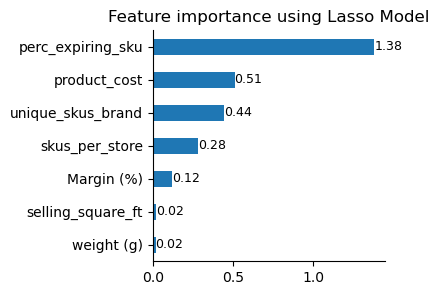


----------------- DT ----------------------


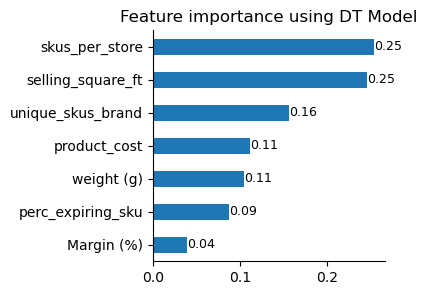

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


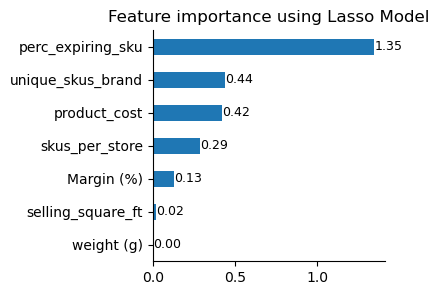


----------------- DT ----------------------


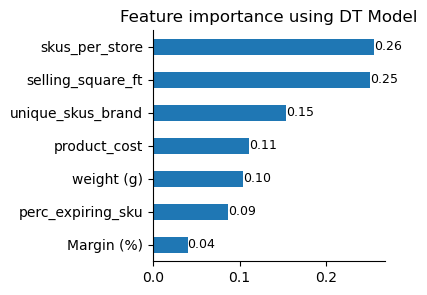

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


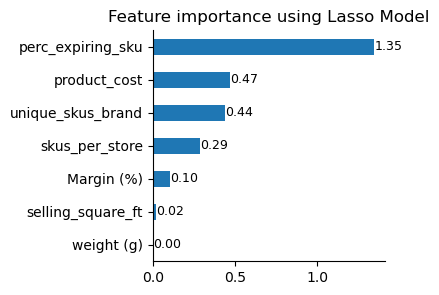


----------------- DT ----------------------


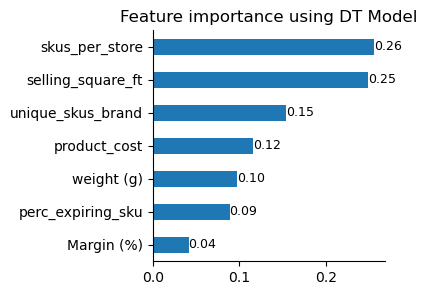

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


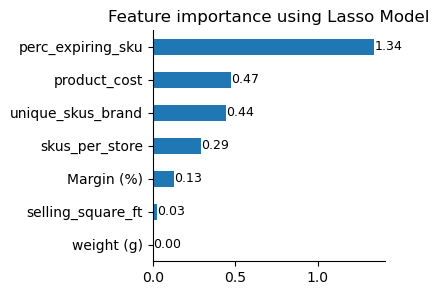


----------------- DT ----------------------


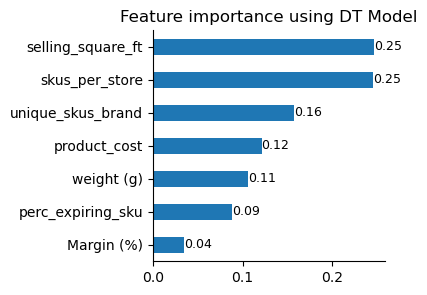

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


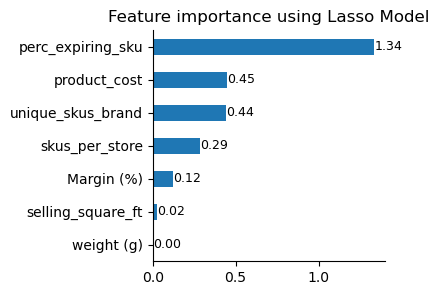


----------------- DT ----------------------


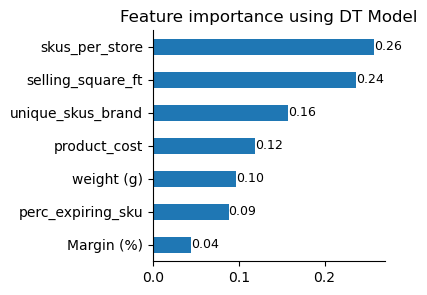

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


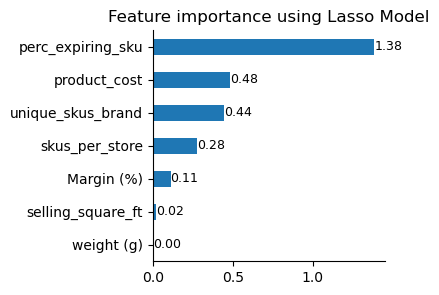


----------------- DT ----------------------


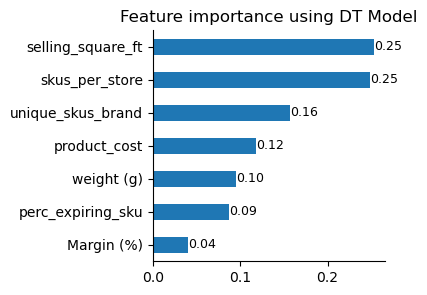

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
weight (g)           False
Margin (%)           False
perc_expiring_sku     True
selling_square_ft    False
skus_per_store        True
unique_skus_brand     True
product_cost          True
dtype: bool

----------------- LASSO ----------------------


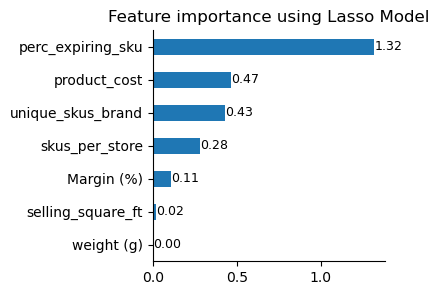


----------------- DT ----------------------


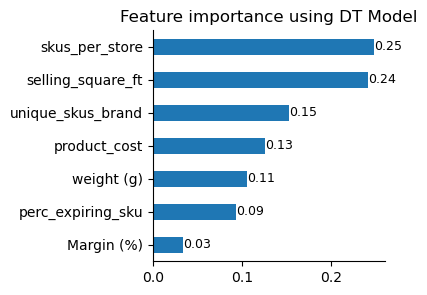

In [399]:
select_best_features(X, y)

The combination of the results obtained earlier is carried out to understand which are the most important variables: <br>

#### 4.2.5.4 Feature Selection Analysis (Lasso, DT, and RFE)
| Feature         | Appearances in the Top 4 (Lasso) | Appearances in the Top 4 (DT) | Average Appearances as True (RFE) | Approach | 
|---------------------|----------------------------|--------------------------|-------------------------------------|-----|
| `weight (g)`        | -                          | -                        | -                                   |REMOVE|
| `Margin (%)`        | -                          | -                        | -                                   |REMOVE|
| `perc_expiring_sku` | 7                          | -                        | 7                              |NCERTAINTY|
| `selling_square_ft` | -                          | 7                        | -                              |NCERTAINTY|
| `skus_per_store`    | 7                          | 7                        | 7                                   |KEEP|
| `unique_skus_brand` | 7                          | 7                        | 7                                   |KEEP|
| `product_cost`      | 7                          | 7                        | 7                                   |KEEP|


At this step, we can identify certain variables that seem to be more important to keep, specifically `skus_per_store`, `unique_skus_brand`, and `product_cost`.

However, there are other variables for which there is greater uncertainty regarding their relevance: `perc_expiring_sku` and `selling_square_ft`.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 5. Modelling and Evaluation
</a>
    
</div>

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.1. Model Selection
    
</div> 

At this step, two datasets are created (`keep_data` and `all_data`), based on the evaluation of the most important variables:

- __`keep_data`__: constructed from the most important variables defined by the feature selection techniques applied earlier.<br>
Variables: `type`, `region`, `labelling_day_of_week`, `marca_2`, `skus_per_store`, `unique_skus_brand`, `product_cost`

- __`all_data`__: constructed from both the most important variables and those for which we have doubts about their use.<br>
Variables: `type`, `region`, `labelling_day_of_week`, `marca_2`, `skus_per_store`, `unique_skus_brand`, `product_cost`, `perc_expiring_sku`, and `selling_square_ft`

In [422]:
keep_data = df_most_recent[['type','region','labelling_day_of_week','marca_2','skus_per_store','unique_skus_brand','product_cost','sold']].copy()	
all_data = df_most_recent[['type','region','labelling_day_of_week','marca_2','skus_per_store','unique_skus_brand','product_cost','perc_expiring_sku','selling_square_ft','sold']].copy()	

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.2. Data Preparation - Train - Test Split 
    
</div> 

Split into __training data__ (90%) and __test data__ (10%) in a stratified manner based on the target variable:

In [426]:
X_keep_data = keep_data.iloc[:,:-1]
y_keep_data = keep_data.iloc[:,-1]

X, X_test, y, y_test = train_test_split(X_keep_data, y_keep_data, 
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_keep_data)
keep_data = pd.concat([X, y], axis=1)

In [428]:
X_all_data = all_data.iloc[:,:-1]
y_all_data = all_data.iloc[:,-1]
X, X_test, y, y_test = train_test_split(X_all_data, y_all_data,           
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_all_data)
all_data = pd.concat([X, y], axis=1)

In [430]:
def transform_data(X_train, X_2nd_df = False, X_2nd_df_flag = False):
    
    ########################################## CREATE DUMMIES #################################################    
    X_train_dummies = pd.get_dummies(X_train)
    X_train_dummies.drop('region_Sul', axis = 1, inplace = True)
    X_train_dummies.drop('type_Medium', axis = 1, inplace = True)
    X_train_dummies.drop('marca_2_yes', axis = 1, inplace = True)
    X_train_dummies.drop('labelling_day_of_week_3', axis = 1, inplace = True)
    
    ############################################ SCALE DATA ###################################################    
    scaler = FunctionTransformer(np.log1p)
    X_train_scaled = scaler.fit_transform(X_train_dummies)
    X_train_scaled = np.log1p(X_train_dummies)
    X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train_dummies.columns)
    
    if X_2nd_df_flag == True: 
        
        ########################################## CREATE DUMMIES #############################################
        X_2nd_df_dummies = pd.get_dummies(X_2nd_df)
        X_2nd_df_dummies.drop('region_Sul', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('type_Medium', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('marca_2_yes', axis = 1, inplace = True)
        X_2nd_df_dummies.drop('labelling_day_of_week_3', axis = 1, inplace = True)
        missing_cols = set(X_train_dummies.columns ) - set(X_2nd_df_dummies.columns )
        
        for c in missing_cols:
            X_2nd_df_dummies[c] = 0
        
        X_2nd_df_dummies = X_2nd_df_dummies[X_train_dummies.columns]
        
        if 'sold' in X_2nd_df_dummies.columns:
            X_2nd_df_dummies.drop(['sold'], axis=1, inplace=True)
        else:
            pass
        
        ############################################ SCALE DATA ###################################################    
        X_2nd_df_scaled = scaler.transform(X_2nd_df_dummies)
        X_2nd_df_scaled = pd.DataFrame(X_2nd_df_scaled , columns = X_2nd_df_dummies.columns, index = X_2nd_df_dummies.index )
        
   
    if X_2nd_df_flag == False:
        return X_train_scaled
    else:
        return X_train_scaled, X_2nd_df_scaled

In [432]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits=7, random_state=99, shuffle=True)
    X = data.drop('sold', axis=1)
    y = data['sold'].copy()

    metrics = {
        "f1_train": [], "f1_val": [],
        "recall_train": [], "recall_val": [],
        "precision_train": [], "precision_val": [],
        "accuracy_train": [], "accuracy_val": [],
        "time": []
    }
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag=True)
        
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        elapsed_time = time.time() - start_time
        
        metrics["f1_train"].append(f1_score(y_train, predictions_train, average="weighted"))
        metrics["f1_val"].append(f1_score(y_val, predictions_val, average="weighted"))
        metrics["recall_train"].append(recall_score(y_train, predictions_train, average="weighted"))
        metrics["recall_val"].append(recall_score(y_val, predictions_val, average="weighted"))
        metrics["precision_train"].append(precision_score(y_train, predictions_train, average="weighted"))
        metrics["precision_val"].append(precision_score(y_val, predictions_val, average="weighted"))
        metrics["accuracy_train"].append(accuracy_score(y_train, predictions_train))
        metrics["accuracy_val"].append(accuracy_score(y_val, predictions_val))
        metrics["time"].append(elapsed_time)

    avg_metrics = {key: round(np.mean(values), 4) for key, values in metrics.items()}
    std_metrics = {key: round(np.std(values), 4) for key, values in metrics.items()}

    return avg_metrics, std_metrics

In [434]:
def show_results(df, data, *args):
    count = 0
    for arg in args:
        avg_metrics, std_metrics = select_best_models(data, arg)
        
        df.iloc[count] = [
            f"{avg_metrics['f1_train']}+/-{std_metrics['f1_train']}",
            f"{avg_metrics['f1_val']}+/-{std_metrics['f1_val']}",
            f"{avg_metrics['recall_train']}+/-{std_metrics['recall_train']}",
            f"{avg_metrics['recall_val']}+/-{std_metrics['recall_val']}",
            f"{avg_metrics['precision_train']}+/-{std_metrics['precision_train']}",
            f"{avg_metrics['precision_val']}+/-{std_metrics['precision_val']}",
            f"{avg_metrics['accuracy_train']}+/-{std_metrics['accuracy_train']}",
            f"{avg_metrics['accuracy_val']}+/-{std_metrics['accuracy_val']}",
            f"{avg_metrics['time']}"
        ]
        count += 1
    return df

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 5.3. Algorithm Comparison and Selection 
    
</div>

Next, the various prediction models are initialized, with training and validation to follow.<br>
The following models will be initialized:
- `Logistic Regression (LR)`
- `K-Nearest Neighbors (KNN)`
- `Decision Tree (DT)`
- `Random Forest Classifier (RFC)`
- `Naive Bayes (NB)`
- `Gradient Boosting Classifier (GBC)`
- `AdaBoost Classifier (ABC)`
- `Support Vector Classifier (SVC)`
- `Multi-layer Perceptron (MLP)`

In [438]:
model_LR = LogisticRegression(max_iter=1000)
model_KNN = KNeighborsClassifier(n_neighbors=5, weights="distance", p=1)
model_DT = DecisionTreeClassifier(max_depth = 15, min_samples_split = 10, min_samples_leaf=5,class_weight="balanced", random_state = 99)
model_RFC = RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=200,max_features='sqrt', random_state=99)
model_NB = GaussianNB()
model_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, min_samples_split=5, min_samples_leaf=3, subsample=0.8, random_state=99) 
model_ABC = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, learning_rate=0.5, random_state=99)
model_SVC = SVC(C=0.1, kernel='linear')
model_MLP = MLPClassifier()

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.1. Training and Validation - Dataset all_data 

In [291]:
df_all = pd.DataFrame(columns=['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'],
                      index=['Logistic Regression', 'KNN', 'DT', 'RFC', 'NB','GBC', 'ABC','SVC','MLP'])

In [453]:
show_results(df_all, all_data, model_LR, model_KNN, model_DT, model_RFC, model_NB, model_GBC, model_ABC, model_SVC, model_MLP)

F1 Train    F1 Validation     Recall Train  \
Logistic Regression  0.6236+/-0.0008  0.6233+/-0.0044  0.6351+/-0.0008   
KNN                  0.8123+/-0.0005  0.7109+/-0.0036   0.812+/-0.0005   
DT                   0.7217+/-0.0017  0.6816+/-0.0039  0.7222+/-0.0017   
RFC                  0.8031+/-0.0006  0.7218+/-0.0036  0.8038+/-0.0006   
NB                   0.6153+/-0.0008  0.6152+/-0.0048  0.6297+/-0.0008   
GBC                  0.6487+/-0.0014  0.6476+/-0.0046  0.6538+/-0.0012   
ABC                   0.6646+/-0.001  0.6615+/-0.0043  0.6685+/-0.0009   
SVC                  0.6111+/-0.0008  0.6111+/-0.0047   0.628+/-0.0007   
MLP                  0.6459+/-0.0036  0.6417+/-0.0034   0.652+/-0.0016   

                    Recall Validation  Precision Train Precision Validation  \
Logistic Regression   0.6348+/-0.0042  0.6387+/-0.0009      0.6384+/-0.0047   
KNN                   0.7105+/-0.0036  0.8136+/-0.0004      0.7128+/-0.0035   
DT                    0.6821+/-0.0038  0.7218+/-0.0017      0.6816+/-0.0039   
RFC                   0.7228+/-0.0035  0.8043+/-0.0006      0.7224+/-0.0035   
NB                    0.6296+/-0.0046  0.6347+/-0.0009      0.6347+/-0.0054   
GBC                   0.6527+/-0.0046  0.6542+/-0.0012      0.6529+/-0.0049   
ABC                   0.6654+/-0.0042  0.6686+/-0.0009      0.6655+/-0.0044   
SVC                    0.628+/-0.0044   0.635+/-0.0009       0.635+/-0.0052   
MLP                   0.6478+/-0.0043  0.6533+/-0.0023       0.649+/-0.0057   

                      Accuracy Train Accuracy Validation Running Time  
Logistic Regression  0.6351+/-0.0008     0.6348+/-0.0042       0.6674  
KNN                   0.812+/-0.0005     0.7105+/-0.0036      56.1947  
DT                   0.7222+/-0.0017     0.6821+/-0.0038       0.4728  
RFC                  0.8038+/-0.0006     0.7228+/-0.0035      32.7012  
NB                   0.6297+/-0.0008     0.6296+/-0.0046       0.1547  
GBC                  0.6538+/-0.0012     0.6527+/-0.0046      11.8024  
ABC                  0.6685+/-0.0009     0.6654+/-0.0042      13.4332  
SVC                   0.628+/-0.0007      0.628+/-0.0044    3381.7169  
MLP                   0.652+/-0.0016     0.6478+/-0.0043      643.533

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.2. Training and Validation - Dataset keep_data

In [294]:
df_keep = pd.DataFrame(columns=['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'],
                      index=['Logistic Regression', 'KNN', 'DT', 'RFC', 'NB','GBC', 'ABC','SVC','MLP'])

In [454]:
show_results(df_keep, keep_data, model_LR, model_KNN, model_DT, model_RFC, model_NB, model_GBC, model_ABC, model_SVC, model_MLP)

F1 Train    F1 Validation     Recall Train  \
Logistic Regression  0.6129+/-0.0008  0.6128+/-0.0046   0.628+/-0.0008   
KNN                  0.7933+/-0.0006  0.7033+/-0.0033  0.7931+/-0.0006   
DT                    0.7156+/-0.002  0.6779+/-0.0044   0.716+/-0.0021   
RFC                  0.7949+/-0.0004  0.7137+/-0.0033  0.7954+/-0.0004   
NB                   0.6143+/-0.0009   0.614+/-0.0045  0.6295+/-0.0008   
GBC                   0.6434+/-0.001  0.6419+/-0.0041  0.6512+/-0.0009   
ABC                  0.6554+/-0.0014  0.6524+/-0.0029   0.661+/-0.0013   
SVC                  0.6111+/-0.0008  0.6111+/-0.0047   0.628+/-0.0007   
MLP                  0.6331+/-0.0024  0.6299+/-0.0055  0.6425+/-0.0019   

                    Recall Validation  Precision Train Precision Validation  \
Logistic Regression   0.6279+/-0.0043  0.6334+/-0.0009      0.6333+/-0.0051   
KNN                    0.703+/-0.0033  0.7941+/-0.0005      0.7047+/-0.0035   
DT                    0.6783+/-0.0044  0.7156+/-0.0021      0.6778+/-0.0044   
RFC                   0.7143+/-0.0033  0.7954+/-0.0004      0.7138+/-0.0033   
NB                    0.6292+/-0.0043  0.6352+/-0.0009       0.635+/-0.0051   
GBC                   0.6497+/-0.0041  0.6533+/-0.0009      0.6518+/-0.0045   
ABC                   0.6581+/-0.0027  0.6622+/-0.0013      0.6592+/-0.0029   
SVC                    0.628+/-0.0044   0.635+/-0.0009       0.635+/-0.0052   
MLP                   0.6395+/-0.0049  0.6452+/-0.0027      0.6421+/-0.0056   

                      Accuracy Train Accuracy Validation Running Time  
Logistic Regression   0.628+/-0.0008     0.6279+/-0.0043       0.5946  
KNN                  0.7931+/-0.0006      0.703+/-0.0033      15.8553  
DT                    0.716+/-0.0021     0.6783+/-0.0044       0.3335  
RFC                  0.7954+/-0.0004     0.7143+/-0.0033      22.1765  
NB                   0.6295+/-0.0008     0.6292+/-0.0043       0.0959  
GBC                  0.6512+/-0.0009     0.6497+/-0.0041       8.1768  
ABC                   0.661+/-0.0013     0.6581+/-0.0027       10.246  
SVC                   0.628+/-0.0007      0.628+/-0.0044     908.9923  
MLP                  0.6425+/-0.0019     0.6395+/-0.0049     553.7521

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.3.3. Conclusions

The chosen metric for selecting the best models (which will be used for optimization) is the __*F1 Score*__. This is an ideal metric for selecting the best model in many scenarios because it balances *precision* and *recall*.

- When comparing the results obtained from the `all_data` and `keep_data` datasets, considering the above-mentioned metric, it is observed that, generally, the models perform better with `all_data` both in training and validation.<br>

- For the `all_data` dataset, the following results are obtained:

| Model                | F1 Train    | F1 Validation | Difference (Train - Val) |
|----------------------|-------------|---------------|--------------------------|
| **RFC**              | **0.8031 ± 0.0007** | **0.7224 ± 0.0026** | **0.0807**  |
| **KNN**              | **0.8120 ± 0.0006** | **0.7128 ± 0.0031** | **0.0992**  |
| **DT**               | **0.7193 ± 0.0031** | **0.6806 ± 0.0047** | **0.0387**  |
| **ABC**              | **0.6644 ± 0.0014** | **0.6611 ± 0.0030** | **0.0033**  |
| **GBC**              | 0.6482 ± 0.0019 | 0.6472 ± 0.0023 | 0.0010  |
| **LR**               | 0.6236 ± 0.0006 | 0.6233 ± 0.0023 | 0.0003  |

- The __best models__ in validation, in descending order, are:
    - Random Forest Classifier, with an f1-score of 0.722
    - K-Nearest Neighbors, with an f1-score of 0.713
    - Decision Tree, with an f1-score of 0.681
    - AdaBoost Classifier, with an f1-score of 0.664
    <br><br>
- Analyzing __overfitting__:
    - K-Nearest Neighbors is the model with the most overfitting, with a difference between train and validation of around 0.1;
    - Random Forest Classifier and Decision Tree are models with relatively little overfitting, with a difference between train and validation of around 0.08 and 0.03, respectively;
    - AdaBoost Classifier does not suffer from overfitting, but its f1-score value is low;
    
The `Random Forest Classifier` and `Decision Tree` seem to be the most promising models, followed by `K-Nearest Neighbors`.<br>
Thus, we will reject the AdaBoost Classifier and try to improve the remaining models.

<div class="alert alert-block alert-success">

<a class="anchor" id="4th-bullet">

## 5.4. Model Optimization
    
</div></a>

At this stage, hyperparameter optimization will be performed for the best models tested above, selecting the options that result in the best overall performance.

Two optimization methods will be used, including:
1. `Manual Optimization`
2. `GridSearch`


<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.1. K-Nearest Neighbor

In K-Nearest Neighbors (KNN), the hyperparameter `n_neighbors` defines the number of neighbors to be considered during the algorithm. Assuming a small number of neighbors typically leads to overfitting, while using a large value for 'k' tends to result in smoother decision boundaries and may cause underfitting.<br>
That being said, since the model was initialized with `n_neighbors` set to 5 and resulted in overfitting, larger values will be tested.

In [356]:
def point_plot(train, validation, values_try):
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=values_try, y=train.values, color='teal', label='Train')
    sns.pointplot(x=values_try, y=validation.values, color='goldenrod', label='Validation')

    plt.title("F1 Score vs. Number of Neighbors")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()

In [358]:
def get_models_knn(data, values):
    results_avg = {}
    results_std = {}
    for value in values:
        model = KNeighborsClassifier(n_neighbors=value)
        try:
            avg_metrics, std_metrics = select_best_models(data, model)
            results_avg[f'neighbors_{value}'] = avg_metrics
            results_std[f'neighbors_{value}'] = std_metrics
        except Exception as e:
            print(f"Erro ao processar neighbors_{value}: {e}")
    return results_avg, results_std

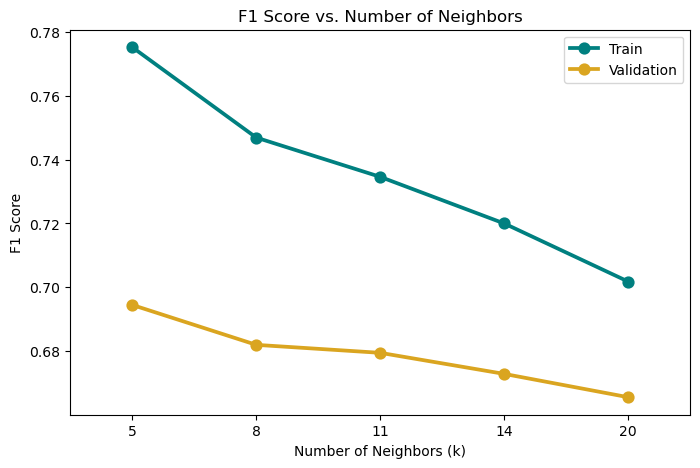

In [360]:
values_try = [5,8,11,14,20]
results_train, results_val = get_models_knn(all_data, values_try)
df_results = pd.DataFrame.from_dict(results_train, orient="index")
df_results_val = pd.DataFrame.from_dict(results_val, orient="index")
point_plot(df_results["f1_train"], df_results["f1_val"], values_try)

Through the analysis of the `n_neighbors - f1-score` graph, it is concluded that the best value for `n_neighbors` that ensures the best tradeoff between the validation f1-score and overfitting is __8__.

In [307]:
final_model_knn = KNeighborsClassifier(n_neighbors = 8)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.1. Decision Trees

Between the optimization methods `RandomizedSearchCV` and `GridSearchCV`, the choice was made to use `GridSearchCV` because we aim to exhaustively explore all hyperparameter combinations to ensure the best possible configuration. Although it is more time-consuming, it guarantees that no promising combination is overlooked.

In [311]:
data = all_data.copy()

X_data = data.drop(['sold'], axis = 1)
y_data = data['sold'].copy()

X_data = transform_data(X_train = X_data, X_2nd_df_flag = False)

In [312]:
dt = DecisionTreeClassifier(max_depth = 2, random_state = 99)

In [313]:
parameter_space_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,12,15,17],
    'min_samples_split': [5, 8,10,15],
    'min_samples_leaf':[5,10,15]
}

In [314]:
grid_search = GridSearchCV(dt, parameter_space_grid, scoring = 'f1', return_train_score = True, cv = 7)

In [315]:
grid_search.fit(X_data, y_data)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best Score:  0.7247003878952627


The best hyperparameters found for the `Decision Tree` were `criterion='entropy'`, `max_depth=17`, `min_samples_leaf=5`, and `min_samples_split=5`, resulting in a score of `0.7247`. These parameters will be used to select the best model.

In [361]:
final_model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 17, min_samples_leaf=5, min_samples_split = 5)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.2. Random Forest

In [319]:
rf = RandomForestClassifier(max_depth=20, min_samples_split=4,n_estimators=200, max_features='sqrt',random_state=99)

In [320]:
parameter_space_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,12,17,20],
    'min_samples_split': [4, 7, 11, 14],
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [321]:
grid_search_rf = GridSearchCV(rf, parameter_space_grid_rf, scoring = 'f1', return_train_score = True, cv = 7)

In [322]:
grid_search_rf.fit(X_data, y_data)

print("Best Hyperparameters: ", grid_search_rf.best_params_)
print("Best Score: ", grid_search_rf.best_score_)

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}
Best Score:  0.751092837147111


The best hyperparameters found for the `Random Forest` were `criterion='entropy'`, `max_depth=20`, `max_features='sqrt'`, `min_samples_split=4`, and `n_estimators=100`, resulting in a score of `0.751`. These parameters will be used for selecting the best model.

In [370]:
final_model_rf = RandomForestClassifier(
    criterion='entropy', 
    max_depth=20, 
    min_samples_split=4, 
    max_features='sqrt', 
    n_estimators=100
)

<div class="alert alert-block alert-info">

<a class="anchor" id="10th-bullet">

### 5.4.3. Selection of the Best Model

<a class="anchor" id="8th-bullet">

#### 5.4.3.1. Performance Comparison
    
</a>

In [374]:
df_final_models = pd.DataFrame(columns = ['F1 Train', 'F1 Validation', 'Recall Train', 'Recall Validation',
                               'Precision Train', 'Precision Validation', 'Accuracy Train', 
                               'Accuracy Validation', 'Running Time'], index = ['Best KNN','Best DT','Best RFC'])
show_results(df_final_models, all_data, final_model_knn, final_model_dt,final_model_rf)

F1 Train    F1 Validation     Recall Train Recall Validation  \
Best KNN  0.7469+/-0.0006   0.682+/-0.0041  0.7468+/-0.0006   0.6818+/-0.0041   
Best DT    0.735+/-0.0032  0.6861+/-0.0043  0.7361+/-0.0031   0.6873+/-0.0042   
Best RFC  0.8004+/-0.0007  0.7202+/-0.0032  0.8012+/-0.0008   0.7213+/-0.0031   

          Precision Train Precision Validation   Accuracy Train  \
Best KNN  0.7535+/-0.0007       0.6881+/-0.004  0.7468+/-0.0006   
Best DT    0.7359+/-0.003      0.6866+/-0.0042  0.7361+/-0.0031   
Best RFC  0.8018+/-0.0008      0.7209+/-0.0032  0.8012+/-0.0008   

         Accuracy Validation Running Time  
Best KNN     0.6818+/-0.0041      25.3655  
Best DT      0.6873+/-0.0042       0.4926  
Best RFC     0.7213+/-0.0031      14.5572

<a class="anchor" id="8th-bullet">

#### 5.4.3.2. ROC Curve    
</a>

In this step, the prediction models will be compared using a ROC curve. The __ROC Curve (Receiver Operating Characteristic)__ is a plot that evaluates the relationship between the true positive rate (sensitivity/recall) and the false positive rate. A curve closer to the top-left corner indicates a better model.

In [377]:
data = all_data.copy()

X_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

In [378]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,
                                                  train_size = 0.9, 
                                                  random_state = 99, 
                                                  stratify = y_data)

In [379]:
X_train, X_val = transform_data(X_train, X_val, X_2nd_df_flag = True)

model_knn = final_model_knn.fit(X_train, y_train)
model_dt = final_model_dt.fit(X_train, y_train)
model_rf = final_model_rf.fit(X_train, y_train)

In [380]:
prob_modelKNN = model_knn.predict_proba(X_val)
prob_modelDT =  model_dt.predict_proba(X_val)
prob_modelRF =  model_rf.predict_proba(X_val)

In [381]:
fpr_modelKNN, tpr_modelKNN, thresholds_modelKNN = roc_curve(y_true = y_val, y_score = prob_modelKNN[:,1])
fpr_modelDT, tpr_modelDT, thresholds_modelDT = roc_curve(y_val, prob_modelDT[:,1])
fpr_modelRF, tpr_modelRF, thresholds_modelRF = roc_curve(y_val, prob_modelRF[:,1])

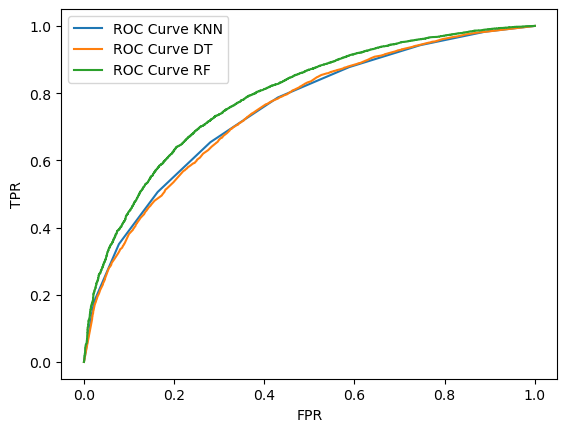

In [382]:
plt.plot(fpr_modelKNN, tpr_modelKNN,label="ROC Curve KNN")
plt.plot(fpr_modelDT, tpr_modelDT, label="ROC Curve DT")
plt.plot(fpr_modelRF, tpr_modelRF, label="ROC Curve RF")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 5.4.4. Conclusions


The __Random Forest Classifier__ shows the best overall performance across the evaluated metrics and has the best ROC curve when compared to the KNN and Decision Tree models. Therefore, it will be the chosen model for our case study.<br>
At this stage, the best hyperparameters for the selected model have been defined. The final adjustment to improve its performance is to modify the *threshold* between a positive and a negative prediction.

In [385]:
final_model = final_model_rf.fit(X_train, y_train)

In [386]:
predict_proba = final_model.predict_proba(X_val)
predict_proba

array([[0.25954191, 0.74045809],
       [0.81459037, 0.18540963],
       [0.61632967, 0.38367033],
       ...,
       [0.37535445, 0.62464555],
       [0.27381607, 0.72618393],
       [0.7154915 , 0.2845085 ]])

Best Threshold=0.373164, F-Score=0.758


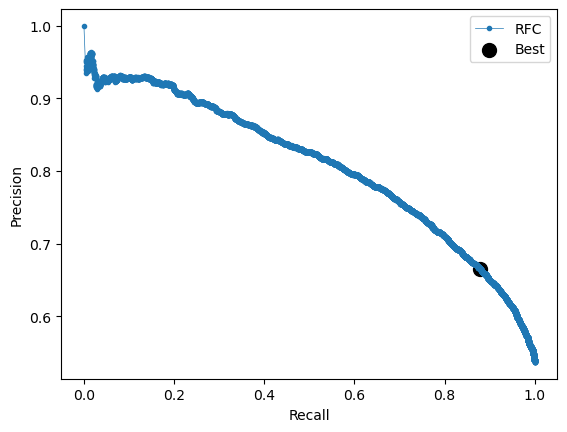

In [424]:
precision, recall, thresholds = precision_recall_curve(y_val, predict_proba[:,1])

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='RFC', linewidth=0.5)
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


Through the analysis of the previous plot, it was observed that by changing the threshold to **0.373164**, we were able to improve the F1-score of our final model.

In [403]:
threshold = 0.373164

<div class="alert alert-block alert-info">

<a class="anchor" id="13th-bullet">

### 5.4.5. Final Model Evaluation

As the final step, the model will be retrained using the optimized parameters, and its overall performance will be evaluated.

In [407]:
train = all_data.copy()

X_train = all_data.drop(['sold'], axis = 1)
y_train = all_data['sold']

In [430]:
X, X_test, y, y_test = train_test_split(X_all_data, y_all_data,           
                                        train_size = 0.9, 
                                        random_state = 99, 
                                        stratify = y_all_data)

In [434]:
X_train, X_test = transform_data(X_train, X_test, X_2nd_df_flag = True)

In [436]:
final_model = final_model_rf.fit(X_train, y_train)

In [437]:
final_model.predict(X_test)

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [439]:
test_pred = []

for value in predict_proba_test[:,1]:
    if (value>=threshold):
        test_pred.append(1)
    else:
        test_pred.append(0)

In [440]:
f1_score(y_test, test_pred)

0.7595634320293927

The model has a good balance between precision and recall, with an F1-score of __76%__.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 6. Final Remarks
</a>
    
</div>

The development of this prediction model for the pink label discount program allowed for an in-depth analysis of consumption patterns and the impact of price reductions on products close to their expiration date. Throughout the different phases of the study, from data preprocessing to hyperparameter optimization of the model, it was possible to structure a predictive system capable of supporting decision-making in pricing strategies and waste reduction.

One of the biggest challenges faced was the quality of the available data, which had various missing values, outliers, and some inconsistencies. To ensure the reliability of the model, a rigorous data cleaning and preparation process was necessary, ensuring that the information used for training accurately reflected consumption patterns and the influence of discounts.

After a comparative analysis of the models tested, the Random Forest Classifier showed the best overall results in the performance metrics analyzed and had the best ROC curve compared to the KNN and Decision Tree models. Therefore, it was the model chosen for this study.

The interpretation of model errors was also crucial, especially regarding the consequences of a false positive (predicting that a product will be sold but it is not) and a false negative (predicting that a product will not be sold but it is). These errors directly impact the efficiency of the discount program:

__False Positives:__ If the model indicates that a product will be sold without needing a discount, but it ends up not being purchased, this results in a total loss of the product's value since it reaches its expiration date unsold. This scenario worsens waste and has a negative financial impact. If the client’s focus is on this, attention should be given to the model's 'recall' metric.

__False Negatives:__ If the model predicts that a product will not be sold and recommends a higher discount than necessary, the store may reduce the price beyond what is needed, thus decreasing its profit margin unnecessarily. As a result, a product that could have been sold with a smaller discount ends up causing a larger financial loss. If the client's focus is on this, attention should be given to the model's 'precision' metric.

Given these issues, it is essential to find a balance between these metrics, considering the client’s strategy and the commercial priorities of the program. The model's decision threshold should be adjusted based on the company's objectives: maximizing sales, reducing waste, or optimizing profit margins.

As next steps, it is recommended to continue refining the model by incorporating new variables that may influence consumer purchasing decisions, such as seasonality, holidays, economic fluctuations, product category, and competitor pricing. Additionally, it will be essential to analyze the evolution of the different labels applied to products over time, not just the most recent discount label, in order to better understand consumption patterns and the effectiveness of different pricing strategies. It would also be important to increase the time window for analysis, enabling the application of Time-Series Crossfold and consequently analyzing the popularity of products/brands in the past.

Given the dominance of marca2 in the dataset, it would be important to test independent models: one for marca2 and another for the remaining brands.

<div class="alert alert-block alert-success">
<a id='preprocess'>
<font color = '#006400'> 
    
# 7. Clustering
</a>
    
</div>

In order to complete the analysis and provide more than just a prediction model, the goal is also to recommend actions that maximize the sale of products close to expiration. Therefore, to complete our prescriptive analysis, a cluster analysis was performed to identify existing data groups and enrich the recommendations.

In [480]:
df_clustering = all_data.copy()

df_clustering.columns

Index(['type', 'region', 'labelling_day_of_week', 'marca_2', 'skus_per_store',
       'unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold'],
      dtype='object')

In [482]:
df_clustering.drop(['region', 'labelling_day_of_week', 'skus_per_store'], axis=1, inplace=True)

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.1. Dummy Variables
    
</div>

In [485]:
df_clust_dummies = pd.get_dummies(df_clustering, columns=['type','marca_2'], drop_first=True)

df_clust_dummies.columns

Index(['unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold', 'type_Medium', 'type_Small',
       'marca_2_yes'],
      dtype='object')

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.2. Power Transformation
    
</div>

The power transformation with logarithms is applied to reduce skewness and make the data distribution closer to normal, with the aim of improving the performance of K-Means and ensuring more balanced clusters.

In [489]:
assymetric_variables = df_clust_dummies[['unique_skus_brand', 'product_cost',
       'perc_expiring_sku', 'selling_square_ft']]

for col in assymetric_variables.columns:
    df_clust_dummies[f"{col}_sqrt"] = np.sqrt(df_clust_dummies[col].clip(lower=0)) 

In [491]:
df_clust_dummies.describe()

df_clust_dummies.columns

Index(['unique_skus_brand', 'product_cost', 'perc_expiring_sku',
       'selling_square_ft', 'sold', 'type_Medium', 'type_Small', 'marca_2_yes',
       'unique_skus_brand_sqrt', 'product_cost_sqrt', 'perc_expiring_sku_sqrt',
       'selling_square_ft_sqrt'],
      dtype='object')

In [493]:
df_clust_dummies.drop(['unique_skus_brand', 'product_cost',
       'perc_expiring_sku', 'selling_square_ft'], axis = 1, inplace = True)

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.3. Normalization
    
</div>

Data normalization is applied to standardize scales and prevent variables with different magnitudes from having a disproportionate impact on the formation of clusters.

In [497]:
numeric_cols = df_clust_dummies.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

df_clust_dummies_scaled = df_clust_dummies.copy()
df_clust_dummies_scaled[numeric_cols] = scaler.fit_transform(df_clust_dummies_scaled[numeric_cols])

df_clust_dummies_scaled.columns

Index(['sold', 'type_Medium', 'type_Small', 'marca_2_yes',
       'unique_skus_brand_sqrt', 'product_cost_sqrt', 'perc_expiring_sku_sqrt',
       'selling_square_ft_sqrt'],
      dtype='object')

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.4. Exploration of the Ideal K
    
</div>

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.1. Elbow Method

The Elbow Method was used to determine the ideal number of clusters in K-Means. <br>
This method evaluates the variation in inertia as the number of clusters increases. <br>
The point where the reduction in inertia starts to slow down indicates the optimal number of clusters, ensuring a balance between granularity and interpretability of the groups.

In [502]:
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k).fit(df_clust_dummies_scaled)
    inertias.append(model.inertia_)

Since k = 2, 3, and 4 present the best trade-off between inertia and the number of groups, K-Means will be applied for each of them. Then, the clusters will be visualized based on two principal components from PCA.

The choice of the best k will be made based on the analysis of the means of the variables in each group and the interpretation of the resulting graphs.

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.2. K-means Clustering

In [517]:
def kmeans_clustering(df_scaled, k, scaler, numeric_cols):
    df_prod_k = df_scaled.copy()
    model_k = KMeans(n_clusters=k, n_init=10, random_state=100).fit(df_prod_k)
    df_prod_k['label'] = model_k.labels_
    dists = euclidean_distances(model_k.cluster_centers_)

    df_unscaled = df_prod_k.copy()
    cols_to_inverse = [col for col in numeric_cols if col in df_unscaled.columns]
    df_unscaled[cols_to_inverse] = scaler.inverse_transform(df_unscaled[cols_to_inverse]) 
    
    return df_prod_k, dists, df_unscaled, model_k

In [519]:
def kmeans_clustering(df_scaled, k, scaler, numeric_cols):
    df_prod_k = df_scaled.copy()
    model_k = KMeans(n_clusters=k, n_init=10, random_state=100).fit(df_prod_k)
    df_prod_k['label'] = model_k.labels_
    dists = euclidean_distances(model_k.cluster_centers_)

    df_unscaled = df_prod_k.copy()
    cols_to_inverse = [col for col in numeric_cols if col in df_unscaled.columns]
    df_unscaled[cols_to_inverse] = scaler.inverse_transform(df_unscaled[cols_to_inverse]) 
    
    return df_prod_k, dists, df_unscaled, model_k

In [521]:
k_visualization = [2, 3, 4]
for k in k_visualization:
    df_prod_k, dists, df_unscaled, model_k = kmeans_clustering(df_clust_dummies_scaled, k, scaler, numeric_cols)
    print(f"Euclidean Distances Between Cluster Centroids:\n{dists}")
    print(f"Mean of each variable per cluster (K = {k}, not scaled):")
    print(df_unscaled.groupby(['label']).mean().transpose())

Euclidean Distances Between Cluster Centroids:
[[0.         2.58797236]
 [2.58797236 0.        ]]
Mean of each variable per cluster (K = 2, not scaled):
label                           0          1
sold                     0.337529   0.618382
type_Medium              0.461763   0.397868
type_Small               0.301254   0.453009
marca_2_yes              0.004563   0.997374
unique_skus_brand_sqrt   3.599177  11.074450
product_cost_sqrt        1.037887   0.907283
perc_expiring_sku_sqrt   0.604951   0.561889
selling_square_ft_sqrt  73.968193  62.661564
Euclidean Distances Between Cluster Centroids:
[[0.         2.04607656 2.94494721]
 [2.04607656 0.         2.65822457]
 [2.94494721 2.65822457 0.        ]]
Mean of each variable per cluster (K = 3, not scaled):
label                           0          1          2
sold                     0.606257   0.632925   0.322645
type_Medium              0.060445   0.708554   0.472006
type_Small               0.939044   0.000000   0.291538
marca_2

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.4.3. PCA for Clustering Visualization

In [524]:
def pca_visualization(df_scaled, model_k): 
    df_pca = df_scaled.copy()
    df_pca['cluster'] = df_pca['label']
    df_pca_numeric = df_pca.drop(columns=['label', 'cluster'])
    
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df_pca_numeric)
    
    df_pca['PCA1'] = pca_components[:, 0]
    df_pca['PCA2'] = pca_components[:, 1]

    return df_pca

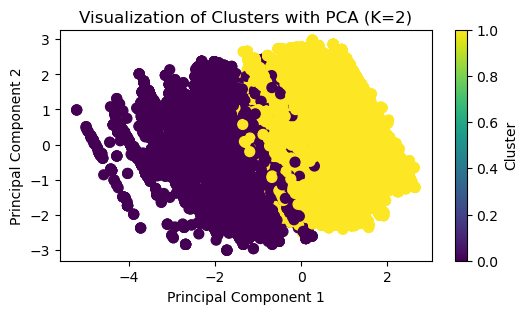

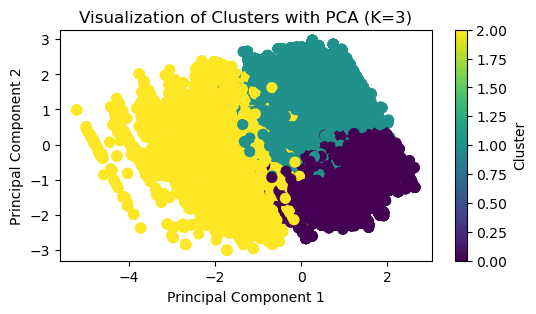

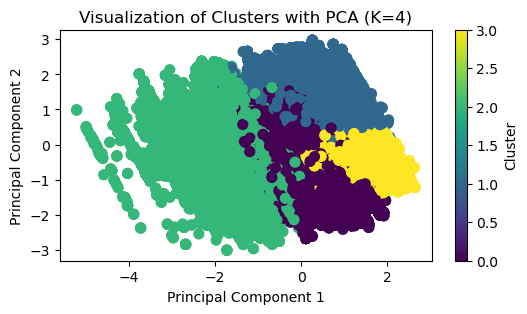

In [536]:
k_visualization = [2, 3, 4]
for k in k_visualization:
    df_prod_k, dists, df_unscaled, model_k = kmeans_clustering(df_clust_dummies_scaled, k, scaler, numeric_cols)
    df_pca = pca_visualization(df_prod_k, model_k)
    
    plt.figure(figsize=(6, 3))
    plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
    plt.title(f'Visualization of Clusters with PCA (K={model_k.n_clusters})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.5. K Choice: K=3
    
</div>

Based on the analysis of the graphical visualizations and the means of the variables in each group, it is concluded that the ideal number of clusters is 3, as it provides the best separation between groups, ensuring greater internal coherence and distinction between segments.

In [529]:
df_k_2, dists_3, df_unscaled_3, model_k_3 = kmeans_clustering(df_clust_dummies_scaled, 3, scaler, numeric_cols)

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### 7.5.1 Revert SQRT

Since the transformation was done using the square root, the reversal will now be applied to recover the original values of the transformed variables.

In [540]:
def revert_sqrt_columns(df):
    sqrt_cols = [col for col in df.columns if col.endswith('_sqrt')]
    
    for col in sqrt_cols:
        new_col = col.replace('_sqrt', '')
        df[new_col] = df[col] ** 2
        df.drop(col, axis=1, inplace=True)
    
    return df

df_unscaled_3 = revert_sqrt_columns(df_unscaled_3)


print("Mean of each variable per cluster (K = 3, unscaled):")
display(df_unscaled_3.groupby(['label']).mean().transpose())

Mean of each variable per cluster (K = 3, unscaled):


label                        0            1            2
sold                  0.606257     0.632925     0.322645
type_Medium           0.060445     0.708554     0.472006
type_Small            0.939044     0.000000     0.291538
marca_2_yes           0.978063     0.989929     0.000905
unique_skus_brand   120.664423   122.023158    14.205349
product_cost          0.825345     0.857962     1.123977
perc_expiring_sku     0.361906     0.377179     0.424813
selling_square_ft  1076.125128  9096.905509  6858.341139

<div class="alert alert-block alert-warning">

<a id='visual'></a>

## 7.6. Cluster Analysis
    
</div>

| Cluster | Name                   | sold (%) | Medium Store (%) | Small Store (%) | Marca 2 (%) | Unique SKUs | Cost (€) | Shelf Life (%) | Sales Area (sqft) | Description |
|---------|------------------------|----------|------------------|-----------------|-------------|-------------|----------|-----------------|-------------------|-------------|
| **0**   | **Best Sellers**        | 63.3%    | **70.9%**        | 0%              | **99.0%**   | **122**     | 0.86     | 37.7%           | **9094**           | Medium stores with large sales areas, strong presence of Marca 2 (which has a large variety of SKUs) |
| **1**   | **Compact Efficiency**  | 60.6%    | 6.0%             | **93.9%**       | **97.8%**   | **120**     | 0.82     | 36.2%           | 1076               | Small stores with smaller sales areas and good presence of Marca 2 (which has a large variety of SKUs). |
| **2**   | **Low Performance**     | 32.3%    | 47.3%            | 29.0%           | 0.08%       | 14          | **1.12**  | **42.4%**       | 6862               | Stores with almost no presence of Marca 2 and brands with low SKU diversity and higher-cost products. |


**Cluster 0:** Although they are the best sellers of products near their expiration date, there is room for improvement. Since it is mainly composed of medium-sized stores, the strategy could include:

1. **Creation of Themed Discount Areas:** As medium-sized stores have **space to organize promotions**, create **discount areas for near-expiry products** in central areas of the store to attract the attention of customers walking through the aisles. This strategy wouldn't work as well in small stores, where space is limited, nor in large stores, where the focus is on variety rather than specific promotions.

2. **Progressive Discounts Based on Volume:** Offer **progressive discounts** such as **"Buy 3, pay for 2"** or **"10% off for each additional unit"**. Medium-sized stores can easily accommodate this type of promotion, encouraging larger purchases. In small stores, space is limited, making this strategy unfeasible.

5. **Use of Space to Organize Products by Categories:** Organize products by expiration categories, giving prominence to those close to their expiration date in specific sections. Medium-sized stores have enough space to create a **"promotion zone"**, something that would be difficult in small stores where space is limited.

---

**Cluster 1:** The effectiveness of labels is slightly lower in this cluster and, as with the previous one, there is still room to improve the labelling strategy for products near expiration. Since this cluster is primarily composed of small stores, the strategy could be:

1. **Strategic Positioning at the Checkout:** Since space is limited, place near-expiry products next to the checkout. The proximity to payment increases the chance of impulse purchases, which is essential in small stores.

2. **Discounts on Purchases of 1 or 2 Products:** In small stores, customers generally don’t buy in large quantities. Strategies like "Discount on the second unit" or "Buy 1, get the second at 50% off" could be more effective in encouraging quick, smaller purchases.

---

**Cluster 2:** Cluster 2 mainly consists of low-performing products when discount labels for near-expiry items are used. It is noteworthy that this cluster is primarily composed of products that are not from Marca 2, which are brands with fewer SKUs.

Strategies for this cluster would be:

2. **Increase Discounts:** To generate higher customer engagement with these products that are close to expiration.

3. **Place Discount Labels Sooner:** Although these products have a longer shelf life compared to the other clusters, extending this window further could help increase sales.

If increasing the discount and extending the time for the discount labels does not result in higher sales for these products, it would make sense to analyze whether reducing order sizes from suppliers would be a viable option, as it could reduce the quantity of products subject to discounts just to avoid expiration. This way, it would be possible to reduce the costs associated with waste, ensuring a more efficient stock management.